Ilinca Bianca Mitrea Mitrea 100495772

David Mancebo Barrena 100495917

# 1.EDA

Importaciones previas 

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier

## Número de variables e instancias

In [2]:
df = pd.read_csv("attrition_availabledata_08.csv")
print("Número de instancias:", df.shape[0])
print("Número de variables:", df.shape[1])


Número de instancias: 2940
Número de variables: 31


## Tipo de variables

Identificamos el tipo de cada variable en el dataset. Esto nos servirá para determinar cómo debemos preprocesar los datos.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      2940 non-null   float64
 1   absences                 2940 non-null   int64  
 2   JobInvolvement           2940 non-null   int64  
 3   PerformanceRating        2940 non-null   int64  
 4   EnvironmentSatisfaction  2923 non-null   float64
 5   JobSatisfaction          2928 non-null   float64
 6   WorkLifeBalance          2916 non-null   float64
 7   Age                      2940 non-null   int64  
 8   BusinessTravel           2940 non-null   object 
 9   Department               2940 non-null   object 
 10  DistanceFromHome         2940 non-null   int64  
 11  Education                2940 non-null   int64  
 12  EducationField           2940 non-null   object 
 13  EmployeeCount            2940 non-null   int64  
 14  EmployeeID              

In [4]:
# Seleccionar variables numéricas
numeric_vars = df.select_dtypes(include=['number'])
print("Variables numéricas:", numeric_vars.columns)
print("Número de variables numéricas:", len(numeric_vars.columns))

# Seleccionar variables categóricas
categorical_vars = df.select_dtypes(include=['object'])
print("Variables categóricas:", categorical_vars.columns)
print("Número de variables categóricas:", len(categorical_vars.columns))

Variables numéricas: Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID',
       'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')
Número de variables numéricas: 23
Variables categóricas: Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'Attrition'],
      dtype='object')
Número de variables categóricas: 8


In [5]:
cardinality = categorical_vars.nunique().sort_values(ascending=False)
print("Cardinalidad de cada variable categórica:")
print(cardinality)

Cardinalidad de cada variable categórica:
JobRole           9
EducationField    6
Department        3
BusinessTravel    3
MaritalStatus     3
Gender            2
Attrition         2
Over18            1
dtype: int64


Observamos que las variables con mayor cardinalidad son JobRole, con una cardinalidad de 9, y EducationField, con una cardinalidad de 6. Tenemos una cardinalidad moderada en general, lo que significa que One-Hot Encoding para transformar las variables categóricas es viable sin generar un número excesivo de columnas. 


## Columnas constantes e identificadores

Vamos a detectar conlumnas constantes que no aportan información útil para la predicción sino que solo aumenta la carga computacional. 

In [6]:
# Contar valores únicos por columna
constant_cols = df.nunique()[df.nunique() == 1]

print("Columnas constantes:")
print(constant_cols)

Columnas constantes:
EmployeeCount    1
Over18           1
StandardHours    1
dtype: int64


Es importante también observar si tenemos identificadores únicos en el dataset, ya que no aportan ninguna información útil a la predicción.

In [7]:
# Contar valores únicos en cada columna y compararlos con el número de filas
id_cols = df.nunique()[df.nunique() == df.shape[0]]

print("\nColumnas de ID:")
print(id_cols)


Columnas de ID:
EmployeeID    2940
dtype: int64


## Tipo de problema

En este caso, la variable Attrition indica si un empleado renuncia, por lo que es un problema de clasificación.

## Desbalanceo de datos


In [8]:
# Contar las instancias por cada clase
conteo = df['Attrition'].value_counts()
print("Conteo por clase:")
print(conteo)

# Calcular el porcentaje de cada clase
porcentajes = df['Attrition'].value_counts(normalize=True) * 100
print("\nPorcentaje por clase:")
print(porcentajes)

Conteo por clase:
Attrition
No     2466
Yes     474
Name: count, dtype: int64

Porcentaje por clase:
Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


También podemos visualizar la distribución con un gráfico de barras

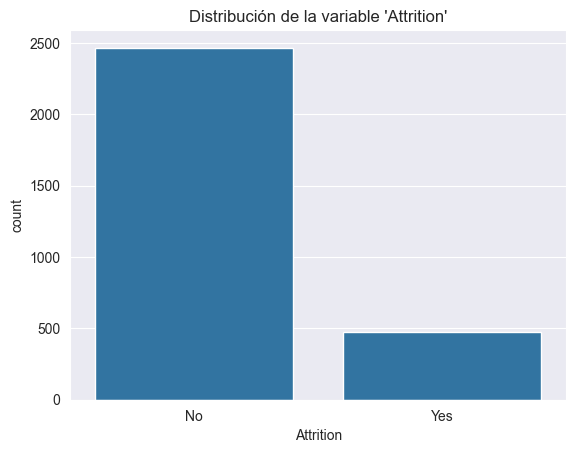

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Attrition', data=df)
plt.title("Distribución de la variable 'Attrition'")
plt.show()


Sí, el dataset está desbalanceado porque la clase mayoritaria ("No" - empleados que no abandonan la empresa) representa el 83.88% de los datos, mientras que la clase minoritaria ("Yes" - empleados que abandonan la empresa) solo representa el 16.12%.
Esto nos hace considerar usar SMOTE para aumentar la clase minoritaria (oversampling)



## Visualización gráfica de los atributos 
Es muy útil  usar seaborn y matplotlib para mostrar los histogramas y barplots de las columnas no constantes/ID para visualizar mejor los datos con los que vamos a trabajar. Además de mostrar la disribución de cada columna hemos dividido cada barra de los gráficos por la clase Attrition, lo que nos permite ver algunos patrones en los datos dependientes de la etiqueta de clasificación.


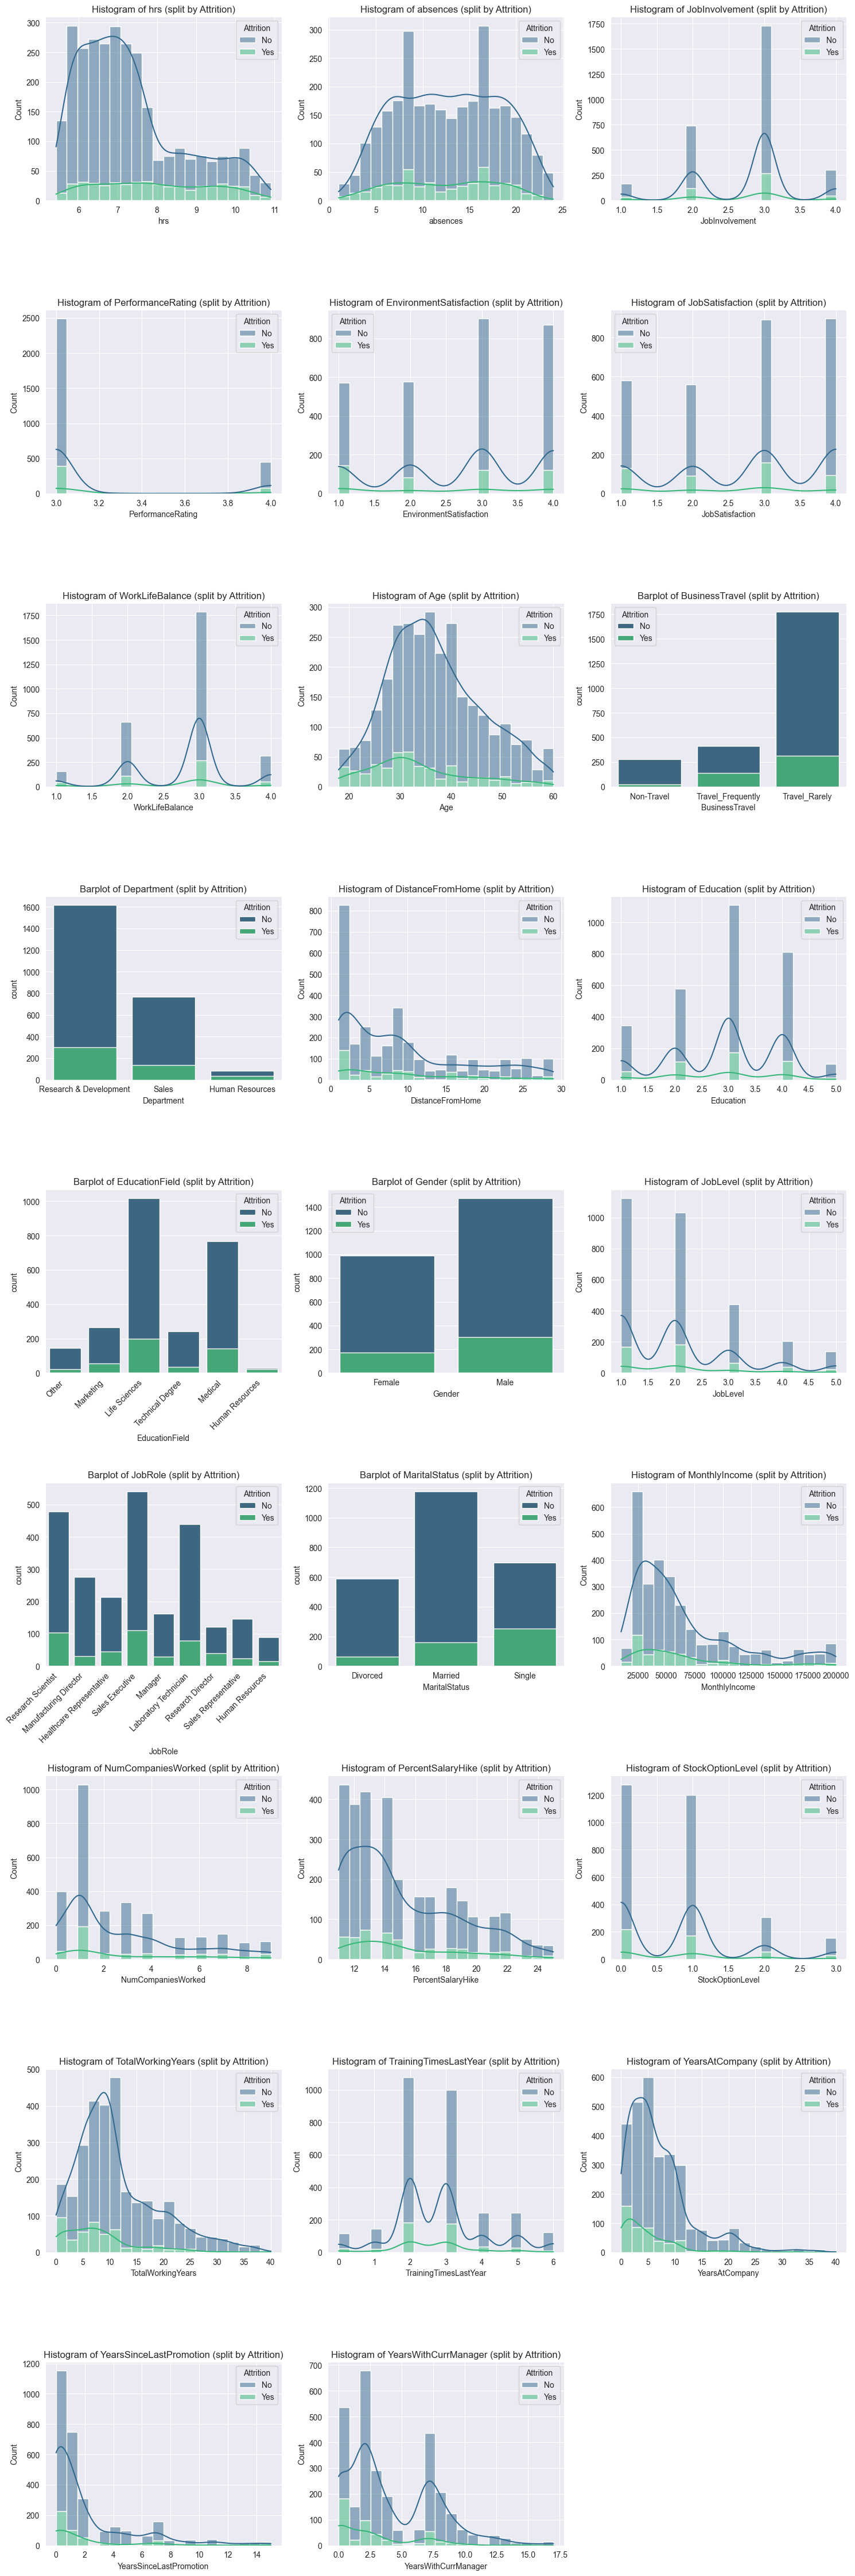

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ignoramos las columnas constantes/ID y Attrition
valid_columns = [col for col in df.columns if col != "Attrition" and df[col].nunique() != 1 and df[col].nunique() != df.shape[0]]
n_cols = len(valid_columns)
n_rows = (n_cols // 3) + (1 if n_cols % 3 != 0 else 0)  # mostramos los histogramas en 3 columnas 

# Figure para mostrar los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Iteramos sobre las columnas válidas del dataset para mostrar los plots de cada una
for idx, column in enumerate(valid_columns, 1):
    plt.subplot(n_rows, 3, idx)
    
    # Definimos histograma (num) o barplot (cat) dependiendo del tipo de datos
    
    # Variables numéricas
    if df[column].dtype in ['int64', 'float64']:
        sns.histplot(df, x=column, hue="Attrition", kde=True, bins=20, palette='viridis', multiple="stack")
        plt.title(f"Histogram of {column} (split by Attrition)")
        
    # Variables categóricas
    elif df[column].dtype == 'object':
        sns.countplot(x=df[column], hue=df["Attrition"], palette='viridis', dodge=False)
        plt.title(f"Barplot of {column} (split by Attrition)")
        
        # Si hay más de 4 categorías rotamos las labels para que no intersecten
        if df[column].nunique() > 4:
            plt.xticks(rotation=45, ha='right')
 
    plt.tight_layout()  # Para evitar que los plots intersecten entre ellos

plt.show()


Algunos patrones presentes en los datos dependientes de la clase que hemos podido visualizar son los siguientes:
- La variable hrs muestra un pico entre los valores 6 y 7, pero este pico no se ve reflejado en las instancias de la clase positiva, lo que puede indicar que los empleados con un número bajo de horas son menos propensos al abandono/agotamiento.
- La variable MaritalStatus muestra un gran porcentaje de la clase positiva en las instancias con valor single, lo que puede indicar que las personas solteras son más propensas al abandono/agotamiento.
- La variable JobSatisfaction muestra muchas más intancias para valores altos (3 y 4), pero el número de instancias positivas para estos valores es muy similar a los valores bajos, lo que indica que una satisfacción laboral alta reduce la probabilidad de que un empleado abandone.  
- La variable YearsWithCurrManager muestra que la mayoría de las instancias positivas tienen valores bajos, lo que podría indicar que cuantos más años lleva una persona con su manager actual menos propensa es al abandono/agotamiento.

El resto de variables no muestran patrones tan claros en la división de los datos por clase, lo que podría indicar que no son tan influyentes para el abandono/agotamiento de un empleado.

Después de un primer contacto con los datos, hemos identificado los pasos relevantes del preprocesamiento de los datos para preparar el dataset antes de entrenar el modelo. Haremos lo siguiente:
1. Eliminar columnas irrelvenates: identificadores úncios y variables constantes.
2. Manejar valores faltantes mediante imputación.
2. Codificar variables categóricas y ordinales.
3. Escalar variables numéricas.
4. Manejar el desbalanceo de clases mediante SMOTE.

Vamos a hacer el preproceso de datos mediante un pipeline para evitar information leakage.

Usaremos un pipeline de preprocesamiento que incluya:

- Encoding (One-Hot y Label/Ordinal Encoding según corresponda)
- Imputación de valores faltantes

Esto asegurará que el preprocesamiento se realice de manera consistente en train y test, evitando errores y asegurando reproducibilidad.

Pero antes de hacer el pipeline, podemos hacer:
- Eliminación de atributos constantes
- Eliminación de identificadores

Estas eliminaciones son transformaciones independeientes del conjunto de entrenamiento y no introducen riesgos de data leakage por lo que se pueden realizar una sola vez antes del entrenamiento.

## Eliminar atributos constantes e identificadores

Ya hemos visto previamente que tenemos 3 columnas constantes y una columna ID. Vamos a eliminarlas porque no aportan información relevante.

In [11]:
original_columns = set(df.columns)

id_columns = ['EmployeeID'] 
df = df.drop(columns=id_columns, errors='ignore')

# Eliminar columnas constantes
constant_columns = [col for col in df.columns if df[col].nunique() <= 1]
df = df.drop(columns=constant_columns, errors='ignore')

# Mostrar las columnas eliminadas
removed_columns = original_columns - set(df.columns)
if removed_columns:
    print("Columnas eliminadas:")
    print(list(removed_columns))
else:
    print("No se eliminaron columnas.")

Columnas eliminadas:
['EmployeeCount', 'Over18', 'EmployeeID', 'StandardHours']


Después de haber eliminado los atributos innecesarios, vamos a volver a visualizar los atributos restantes y su clasificación.

In [12]:
# Variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
print("Variables categóricas:", categorical_cols)


Variables categóricas: Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Attrition'],
      dtype='object')


Vamos a identificar las variables ordinales dentro de las variables categóricas para determinar qué tipo de encoding haremos para cada variable en función de si es categórica nominal u ordinal.

In [13]:
# Valores únicos por cada variable categórica
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].unique())



BusinessTravel:
['Non-Travel' 'Travel_Frequently' 'Travel_Rarely']

Department:
['Research & Development' 'Sales' 'Human Resources']

EducationField:
['Other' 'Marketing' 'Life Sciences' 'Technical Degree' 'Medical'
 'Human Resources']

Gender:
['Female' 'Male']

JobRole:
['Research Scientist' 'Manufacturing Director' 'Healthcare Representative'
 'Sales Executive' 'Manager' 'Laboratory Technician' 'Research Director'
 'Sales Representative' 'Human Resources']

MaritalStatus:
['Divorced' 'Married' 'Single']

Attrition:
['No' 'Yes']


Vemos que todas las variables categóricas con nominales, excepto BusinessTravel que es ordinal porque tiene un orden implícito. La variable target Attrition es binaria.

Para variables ordinales: usamos Label Encoding

Para variables nominales: usamos One-Hot Encoding

Para variables binarias: convertimos a 0 y 1


In [14]:
# Identificar columnas categóricas y numéricas

all_categorical = df.select_dtypes(include=['object']).columns.tolist()

# Eliminar la variable target de las categóricas porque no debe ser preprocesada junto con las variables del conjunto de entrenamiento
target = 'Attrition'
if target in all_categorical:
    all_categorical.remove(target)
    
# Definimos la variable ordinal
ordinal_cols = ['BusinessTravel']

# Las columnas categóricas nominales serán las categóricas menos las ordinales
categorical_cols = [col for col in all_categorical if col not in ordinal_cols]

numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

# Imprimimos resultados
print("Number of ordinal columns:", len(ordinal_cols))
print("Ordinal columns:", ordinal_cols)
for col in ordinal_cols:
    # Obtener valores únicos y ordenarlos
    ordinal_values = [sorted(df[col].dropna().unique()) for col in ordinal_cols]
    print("Values of ", ordinal_cols, ": ", ordinal_values)
print("Number of nominal columns:", len(categorical_cols))
print("Nominal columns:", categorical_cols)
print("Number of numerical columns:", len(numerical_cols))
print("Numerical columns:", numerical_cols)

Number of ordinal columns: 1
Ordinal columns: ['BusinessTravel']
Values of  ['BusinessTravel'] :  [['Non-Travel', 'Travel_Frequently', 'Travel_Rarely']]
Number of nominal columns: 5
Nominal columns: ['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
Number of numerical columns: 20
Numerical columns: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


Esta información nos servirá para la parte de encoding dentro de la definición de pipeline que utilizaremos en el preprocesamiento.

## Valores faltantes
Vamos a observar los valores faltantes de nuestro dataset y decidir cómo manejarlos.

In [15]:
# Valores faltantes en variables numéricas
num_missing = df[numerical_cols].isnull().sum()
num_missing_percent = (num_missing / len(df)) * 100

# Filtrar solo las columnas con valores faltantes
missing_numerical = pd.DataFrame({
    'Missing Count': num_missing,
    'Missing Percent': num_missing_percent
}).query('`Missing Count` > 0').sort_values(by='Missing Count', ascending=False)

print("Valores faltantes en variables numéricas:")
if not missing_numerical.empty:
    print(missing_numerical)
else:
    print("No hay valores faltantes en variables numéricas.")

# Valores faltantes en variables categóricas nominales
missing_nominal = df[categorical_cols].isnull().sum()
missing_nominal_percent = (missing_nominal / len(df)) * 100

# Filtrar solo las columnas con valores faltantes
missing_nominal_df = pd.DataFrame({
    'Missing Count': missing_nominal,
    'Missing Percent': missing_nominal_percent
}).query('`Missing Count` > 0').sort_values(by='Missing Count', ascending=False)

print("\nValores faltantes en variables categóricas nominales:")
if not missing_nominal_df.empty:
    print(missing_nominal_df)
else:
    print("No hay valores faltantes en variables categóricas nominales.")

# Valores faltantes en variables ordinales
missing_ordinal = df[ordinal_cols].isnull().sum()
missing_ordinal_percent = (missing_ordinal / len(df)) * 100

# Filtrar solo las columnas con valores faltantes
missing_ordinal_df = pd.DataFrame({
    'Missing Count': missing_ordinal,
    'Missing Percent': missing_ordinal_percent
}).query('`Missing Count` > 0').sort_values(by='Missing Count', ascending=False)

print("\nValores faltantes en variables ordinales:")
if not missing_ordinal_df.empty:
    print(missing_ordinal_df)
else:
    print("No hay valores faltantes en variables ordinales.")


Valores faltantes en variables numéricas:
                         Missing Count  Missing Percent
WorkLifeBalance                     24         0.816327
EnvironmentSatisfaction             17         0.578231
JobSatisfaction                     12         0.408163
NumCompaniesWorked                  11         0.374150
TotalWorkingYears                    4         0.136054

Valores faltantes en variables categóricas nominales:
No hay valores faltantes en variables categóricas nominales.

Valores faltantes en variables ordinales:
No hay valores faltantes en variables ordinales.


Tenemos valores faltantes solo en variables numéricas. Además, con porcentajes muy bajos (menos de 1% en cada una), por lo que el problema es leve. Se considerarán la media y la mediana para imputar los valores numéricos faltantes.

Aunque en nuestro dataset no tenemos valores faltantes en atributos categóricos y ordinales, vamos a utilizar imputación mediante moda para estas variables (ya que no toman valores numéricos, no podemos usar mediana ni media). Esto nos da mayor flexibilidad y robustez por si nuestro dataset cambia en un futuro.

La imputación se debe hacer solo con los datos de entrenamiento, ya que los datos de test son datos del futuro y, por tanto, debemos suponer que no los conocemos para evitar information leakage o fuga de información. 

Para hacer imputación cuando puede ocurrir information leakage, lo correcto es construir un pipeline.

Si tenemos que imputar los atributos del conjunto de test, usaremos las medias o mediana calculadas con el conjunto de entrenamiento (reimputación), para evitar fuga de información del conjunto de test.


## Escalado
Variables numéricas como Age, MonthlyIncome, DistanceFromHome, etc., pueden tener escalas muy diferentes y para modelos como KNN es importante escalar estas variables para dar la misma importancia a todas las variables. Por si acaso, vamos a escalar también las variables categóricas y ordinales después del encoding. Se considerarán tres métodos de escalado (minmax, standard, robust).


# Holdout

La estimación del rendimiento futuro (o evaluación outer) se realizará con Holdout (train (2/3) / test (1/3)). Por ello, antes de empezar con el entrenamiento de los modelos y la optimización de hiperparámetros, debemos dividir los datos en train y test. Antes de esa división en train y test, recordemos que debemos codificar la variable objetivo, convirtiendo attrition de una variable categórica ('No', 'Yes') a valores numéricos como variable binaria (0 y 1).

In [16]:
# SEPARACIÓN ENTRE VARIABLES Y DIVISIÓN TRAIN/TEST
X = df.drop(columns=['Attrition'])
y = df['Attrition']


# Encoding de la variable de decisión
y = y.map({'No': 0, 'Yes': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, random_state=72, stratify=y
)

print(f"Tamaño de Train: {X_train.shape}, Tamaño de Test: {X_test.shape}")


Tamaño de Train: (1960, 26), Tamaño de Test: (980, 26)


## Selección de la mejor estrategia de preprocesamiento

Para evaluar los diferentes métodos de imputación y escalado y encontrar la combinación óptima de hiperparámetros para el preprocesamiento de los datos, seeguiremos la siguiente estrategia:

1. Imputación.

En variables numéricas:
- Media
- Mediana

En variables categóricas y ordinales: moda

2. Escalado en variables numéricas y ordinales.
Evaluamos tres métodos:

- StandardScaler
- MinMaxScaler
- RobustScaler

3. Usar un pipeline que incluya el preprocesamiento (imputación y encoding) y el escalado, seguido de un clasificador KNN.

4. Aplicar GridSearchCV para explorar las combinaciones de imputador y escalador utilizando la métrica balanced accuracy.

In [17]:
from sklearn.model_selection import KFold, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Para variables numéricas: imputación con mediana y escalado
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Para variables categóricas nominales: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Para variables ordinales: OrdinalEncoder con el orden definido
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[["Non-Travel", "Travel_Rarely", "Travel_Frequently"]])),
    ('scaler', StandardScaler())
])

# COMBINACIÓN DE TRANSFORMACIONES (AÚN SIN ESCALADO)
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols),
    ('ord', ordinal_transformer, ordinal_cols)
])


# PIPELINE GLOBAL: PRIMERO TRANSFORMACIÓN, LUEGO ESCALADO
pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessor),  # Primero se hace imputación y encoding
    ('smote', SMOTE(random_state=72)),
    ('classifier', KNeighborsClassifier())
])

# Definir la grilla de parámetros para el GridSearchCV:
param_grid = {
    # Imputación: 'mean' o 'median' para variables numéricas
    'preprocessing__num__imputer__strategy': ['mean', 'median'],
    # Escalado: probar MinMaxScaler, StandardScaler y RobustScaler
    'preprocessing__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
}

# Configurar GridSearchCV usando balanced_accuracy como métrica (dado el desbalanceo)
inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=72)
grid_search = GridSearchCV(pipeline, param_grid, cv=inner, scoring='balanced_accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_preprocessor = grid_search.best_estimator_ # mejor model del INNER LOOP

# Extraer los inner scores de GridSearchCV
inner_scores = pd.DataFrame(grid_search.cv_results_)

# Seleccionar solo las columnas clave
inner_scores = inner_scores[
    ['param_preprocessing__num__imputer__strategy',
     'param_preprocessing__num__scaler',
     'mean_test_score', 'std_test_score', 'rank_test_score']
]

# Ordenar por la mejor precisión balanceada
inner_scores = inner_scores.sort_values(by='mean_test_score', ascending=False)

# Mostrar resultados
print("Resultados de Validación Cruzada (INNER LOOP)")
display(inner_scores)

print("Mejor combinación de parámetros:")
print(grid_search.best_params_)
print("Mejor Balanced Accuracy (CV):", grid_search.best_score_)



Fitting 5 folds for each of 6 candidates, totalling 30 fits
Resultados de Validación Cruzada (INNER LOOP)


,param_preprocessing__num__imputer__strategy,param_preprocessing__num__scaler,mean_test_score,std_test_score,rank_test_score
5,median,RobustScaler(),0.765341,0.029259,1
2,mean,RobustScaler(),0.764058,0.029493,2
1,mean,StandardScaler(),0.754400,0.018499,3
4,median,StandardScaler(),0.753791,0.018288,4
3,median,MinMaxScaler(),0.743545,0.039391,5
0,mean,MinMaxScaler(),0.743241,0.039667,6


Mejor combinación de parámetros:
{'preprocessing__num__imputer__strategy': 'median', 'preprocessing__num__scaler': RobustScaler()}
Mejor Balanced Accuracy (CV): 0.7653412940379404


In [18]:
# Información de ayuda para entender cómo funciona el pipeline
print("Pasos en el preprocesador:")
print(best_preprocessor.steps)

Pasos en el preprocesador:
[('preprocessing', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['hrs', 'absences', 'JobInvolvement',
                                  'PerformanceRating',
                                  'EnvironmentSatisfaction', 'JobSatisfaction',
                                  'WorkLifeBalance', 'Age', 'DistanceFromHome',
                                  'Education', 'JobLevel', 'MonthlyIncome',
                                  'NumCompaniesWorked', 'PercentSalaryHike',...
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
               

Necesitamos X_train_transformed porque el GridSearchCV de KNN trabajará con los datos ya transformados. 

In [19]:
# Transformar los datos de entrenamiento con el mejor preprocesamiento
X_train_transformed = best_preprocessor.named_steps['preprocessing'].transform(X_train)
# Transformar los datos de test con el mejor preprocesamiento
X_test_transformed = best_preprocessor.named_steps['preprocessing'].transform(X_test)
print("Forma de X_train antes de la transformación:", X_train.shape)
print("Forma de X_train antes de la transformación:", X_train.shape)
print("Forma de X_train después de la transformación:", X_train_transformed.shape)


# Para comprobar que ya no hay valores nulos
feature_names = best_preprocessor.named_steps['preprocessing'].get_feature_names_out()
#print(feature_names)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
print(X_train_transformed_df['ord__BusinessTravel'])
print(X_train_transformed_df.isnull().sum().sum())  # Debe ser 0 si la imputación funcionó


Forma de X_train antes de la transformación: (1960, 26)
Forma de X_train antes de la transformación: (1960, 26)
Forma de X_train después de la transformación: (1960, 39)
0      -0.147219
1       1.738729
2      -0.147219
3      -0.147219
4      -0.147219
          ...   
1955   -2.033168
1956   -2.033168
1957    1.738729
1958   -0.147219
1959    1.738729
Name: ord__BusinessTravel, Length: 1960, dtype: float64
0


## Comprobaciones del preprocesamiento

Para verificar que el preprocesamiento se hace correctamente podemos visualizar los datos originales y los datos transformados en dos histogramas.

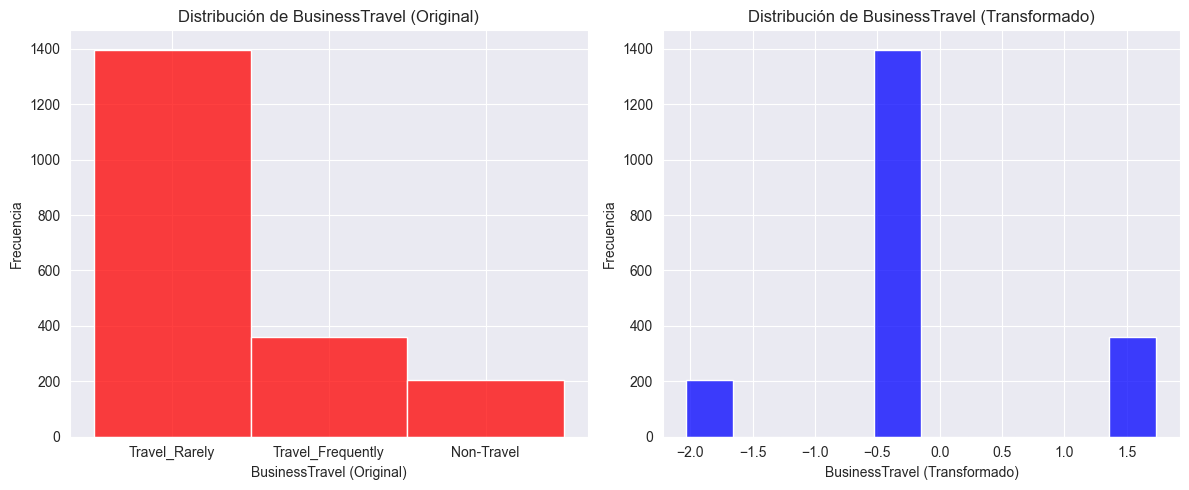

In [68]:
# Crear dos gráficos separados para visualizar la variable ordinal BusinessTravel antes y después de la transformación de OrdinalEncoder()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico 1: Distribución de la variable original
sns.histplot(X_train['BusinessTravel'], bins=10, color="red", ax=axes[0])
axes[0].set_xlabel("BusinessTravel (Original)")
axes[0].set_ylabel("Frecuencia")
axes[0].set_title("Distribución de BusinessTravel (Original)")
axes[0].grid(True)

# Gráfico 2: Distribución de la variable transformada
sns.histplot(X_train_transformed_df['ord__BusinessTravel'], bins=10, color="blue", ax=axes[1])
axes[1].set_xlabel("BusinessTravel (Transformado)")
axes[1].set_ylabel("Frecuencia")
axes[1].set_title("Distribución de BusinessTravel (Transformado)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


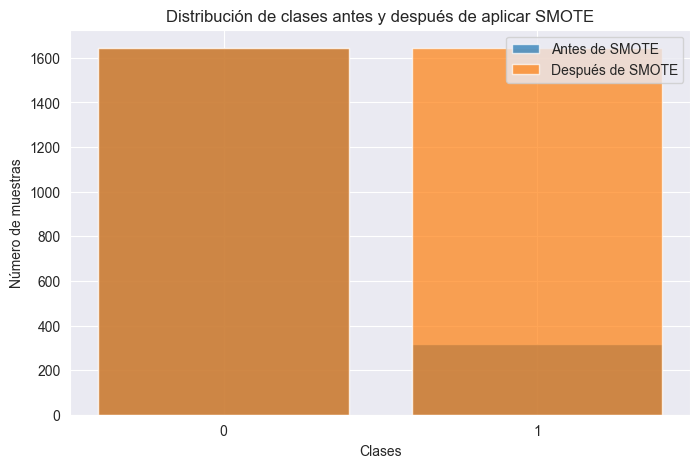

In [69]:
# Para comprobar que SMOTE funciona bien, aplicamos SMOTE fuera de la pipeline para ver la diferencia
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# Contar la distribución de clases antes y después de SMOTE
class_counts_before = y_train.value_counts()
class_counts_after = y_train_resampled.value_counts()

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(class_counts_before.index.astype(str), class_counts_before.values, alpha=0.7, label="Antes de SMOTE")
plt.bar(class_counts_after.index.astype(str), class_counts_after.values, alpha=0.7, label="Después de SMOTE")
plt.xlabel("Clases")
plt.ylabel("Número de muestras")
plt.title("Distribución de clases antes y después de aplicar SMOTE")
plt.legend()
plt.show()


## StratifiedKFold común para GridSearch y cross_val_predict

In [20]:
from sklearn.model_selection import StratifiedKFold

# Usaremos el siguiente StratifiedKFold en todos los GridSearch y en el cálculo de algunas curvas de evaluación inner por cuestiones de consistencia
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=72)

# Hemos apreciado que 10 folds da resultados mejores para algunos modelos, pero hemos decidido usar 5 ya que para algunos modelos con un GridSearch muy amplio 10 folds generaba tiempos de búsqueda demasiado altos

# Dummy Classifier
En el enunciado de la práctica se indica que comparemos los resultados del modelo naive/dummy con los modelos KNN y trees conseguidos, así que vamos a obtener los resultados del dummy classifier primero antes de empezar con los metodos básicos.

In [23]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_transformed, y_train)

DummyClassifier(strategy='most_frequent')

En la fase inner, no debemos usar el conjunto X_test. Por lo tanto, utilizaremos validación cruzada sobre el conjunto de entrenamiento para evaluar y comparar las alternativas sin "filtrar información" (data leakage) al modelo. Esto nos permite obtener estimaciones de rendimiento (como balanced accuracy, TPR, TNR, y la matriz de confusión) basadas únicamente en datos de entrenamiento.



In [72]:
# Generar predicciones usando validación cruzada
y_pred_inner = cross_val_predict(dummy_clf, X_train_transformed, y_train, cv=inner_cv)

# Calcular métricas usando las etiquetas reales del conjunto de entrenamiento
balanced_acc_inner = balanced_accuracy_score(y_train, y_pred_inner)
print(f"Dummy: Balanced Accuracy (inner): {balanced_acc_inner:.4f}")

# Imprimir reporte de clasificación
dummy_cr_inner = classification_report(y_train, y_pred_inner, zero_division=0)
print("Dummy: Classification report (inner):\n", dummy_cr_inner)

# Mostrar la matriz de confusión
conf_matrix_inner = confusion_matrix(y_train, y_pred_inner)
print("Dummy: Matriz de confusión (inner):\n", conf_matrix_inner)

Dummy: Balanced Accuracy (inner): 0.5000
Dummy: Classification report (inner):
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      1644
           1       0.00      0.00      0.00       316

    accuracy                           0.84      1960
   macro avg       0.42      0.50      0.46      1960
weighted avg       0.70      0.84      0.77      1960

Dummy: Matriz de confusión (inner):
 [[1644    0]
 [ 316    0]]


## Métodos básicos: KNN

## KNN: Entrenamiento con hiperparámetros por omisión

El clasificador KNeighborsClassifier de scikit-learn tiene los siguientes parámetros por defecto:

- n_neighbors = 5
- weights = 'uniform': Todos los vecinos tienen el mismo peso (votación uniforme).
- algorithm = 'auto': Se elige automáticamente el algoritmo adecuado (ball_tree, kd_tree o brute force) según los datos.
- leaf_size = 30: Tamaño de hoja para la construcción de Ball Tree o KD Tree.
- p = 2: Se utiliza la distancia de Minkowski con  p=2 (equivalente a la distancia Euclidiana).
- metric = 'minkowski': Métrica de distancia utilizada para calcular las distancias entre puntos.
- metric_params = None: No se especifican parámetros adicionales para la métrica.
- n_jobs = None: No se usa paralelización (se ejecuta en un solo núcleo por defecto).

In [73]:
import time

knn_default = KNeighborsClassifier()  # Hiperparámetros por defecto

start_time = time.time()
knn_default.fit(X_train_transformed, y_train)
default_time_fit = time.time() - start_time
print(f"Tiempo de entrenamiento de KNN default: {default_time_fit:.8f} segundos")


Tiempo de entrenamiento de KNN default: 0.00105643 segundos


### Métricas del KNN default

In [74]:
# Utilizar cross_val_predict para obtener las predicciones mediante validación cruzada
start_time = time.time()
y_pred_cv = cross_val_predict(knn_default, X_train_transformed, y_train, cv=inner_cv)
default_time_predict = time.time() - start_time

# Calcular las métricas sobre el conjunto de entrenamiento (evaluación inner)
default_balanced_accuracy = balanced_accuracy_score(y_train, y_pred_cv)
default_accuracy = accuracy_score(y_train, y_pred_cv)
default_conf_matrix = confusion_matrix(y_train, y_pred_cv)
default_class_report = classification_report(y_train, y_pred_cv, zero_division=0)

# Calcular TPR y TNR a partir de la matriz de confusión
tn, fp, fn, tp = default_conf_matrix.ravel()
TPR = tp / (tp + fn)
TNR = tn / (tn + fp)

# Imprimir los resultados
print("Modelo KNN con hiperparámetros default  (evaluación inner con validación cruzada):")
print(f"Balanced Accuracy: {default_balanced_accuracy:.4f}")
print(f"Accuracy: {default_accuracy:.4f}")
print("\nClassification Report:")
print(default_class_report)
print("Matriz de Confusión:")
print(default_conf_matrix)
print(f"TPR: {TPR:.4f}")
print(f"TNR: {TNR:.4f}")
print(f"\nTiempo de entrenamiento de KNN default: {default_time_fit:.8f} segundos")
print(f"Tiempo de predicción (CV) de KNN default: {default_time_predict:.8f} segundos")

Modelo KNN con hiperparámetros default  (evaluación inner con validación cruzada):
Balanced Accuracy: 0.5994
Accuracy: 0.8469

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1644
           1       0.56      0.23      0.33       316

    accuracy                           0.85      1960
   macro avg       0.71      0.60      0.62      1960
weighted avg       0.82      0.85      0.82      1960

Matriz de Confusión:
[[1586   58]
 [ 242   74]]
TPR: 0.2342
TNR: 0.9647

Tiempo de entrenamiento de KNN default: 0.00105643 segundos
Tiempo de predicción (CV) de KNN default: 0.02662706 segundos


## KNN: Evaluación de alternativas con ajustes de hiper-parámetros (HPO)

Realizaremos una búsqueda de hiperparámetros HPO para optimizar un clasificador KNN utilizando validación cruzada interna.

In [75]:
inner_scores_out = []

# Ahora entrenamos KNN con diferentes valores de n_neighbors
param_grid_knn = {
    'n_neighbors': [2, 3, 4, 5, 6, 7],  # Diferentes valores de vecinos
    'weights': ['uniform', 'distance'],  # Cómo se ponderan los vecinos
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Tipo de métrica
    'p': [3]
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(), param_grid_knn,
    cv=inner_cv, scoring='balanced_accuracy', n_jobs=-1, verbose=3
)

start_time = time.time()
grid_knn.fit(X_train_transformed, y_train)
hpo_time_KNN = time.time() - start_time
print(f"Hiperparámetros óptimos encontrados en {hpo_time_KNN:2f}")

# Crear DataFrame con los resultados de GridSearchCV
inner_scores_df = pd.DataFrame(grid_knn.cv_results_)[
    ['param_n_neighbors', 'param_weights', 'param_metric', 'param_p', 
     'mean_test_score', 'std_test_score', 'rank_test_score']
]

# Añadir los resultados actuales a la lista
inner_scores_out.append(inner_scores_df)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [76]:
# Obtener el mejor modelo KNN
best_knn = grid_knn.best_estimator_
start_time = time.time()
best_knn.fit(X_train_transformed, y_train)
best_knn_fit_time = time.time() - start_time

print("\nHPO KNN:", grid_knn.best_params_)
print(f"Tiempo de entrenamiento (incluyendo HPO): {hpo_time_KNN+best_knn_fit_time:.2f} segundos")
print(f"Tiempo de entrenamiento del modelo KNN default: {default_time_fit:.8f} segundos")
print(f"Factor de incremento en tiempo que supone la HPO y el entrenamiento del mejor modelo vs el default = {(hpo_time_KNN+best_knn_fit_time)/default_time_fit}")


HPO KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'p': 3, 'weights': 'distance'}
Tiempo de entrenamiento (incluyendo HPO): 9.64 segundos
Tiempo de entrenamiento del modelo KNN default: 0.00105643 segundos
Factor de incremento en tiempo que supone la HPO y el entrenamiento del mejor modelo vs el default = 9124.036786278493


Observamos que encontrar los HP óptimos y entrenar el modelo óptimo conlleva mucho más tiempo de cómputo que entrenar el modelo utilizando los HP por defecto.

## Resultados de KNN con HPO: balanced accuracy, TPR / TNR, accuracy y confusion matrix (inner)

Recordemos que durante la optimización de hiperparámetros (evaluación inner), no se debe usar el conjunto de test completo. Por eso aplicamos validación cruzada sobre el conjunto de entrenamiento para estimar el rendimiento de los modelos.

Para evaluar internamente sin usar el conjunto de test, utilizamos la función cross_val_predict para obtener las predicciones de validación para cada muestra del conjunto de entrenamiento, y luego calcular las métricas de interés. 

Realizamos validación cruzada KFold en la que para cada iteración, el modelo se entrena con k-1 folds y se evalúa en el fold restante. En cada fold se calculan métricas como el balanced accuracy, accuracy, y se genera la matriz de confusión


In [77]:
# Utilizamos cross_val_predict para obtener predicciones en validación cruzada sin usar X test de momento
y_pred_cv = cross_val_predict(best_knn, X_train_transformed, y_train, cv=inner_cv)

# Calcular las métricas en el conjunto de entrenamiento (evaluación inner)
inner_bal_acc_hpo_KNN = balanced_accuracy_score(y_train, y_pred_cv)
inner_acc_hpo_KNN = accuracy_score(y_train, y_pred_cv)
inner_conf_matrix_hpo_KNN = confusion_matrix(y_train, y_pred_cv)
inner_class_report_hpo_KNN = classification_report(y_train, y_pred_cv)

print("Evaluación Inner (Validación Cruzada):")
print(f"Balanced Accuracy: {inner_bal_acc_hpo_KNN:.4f}")
print(f"Accuracy: {inner_acc_hpo_KNN:.4f}")
print("Classification Report:")
print(inner_class_report_hpo_KNN)
print("Matriz de Confusión:")
print(inner_conf_matrix_hpo_KNN)

# Calcular TPR y TNR a partir de la matriz de confusión
tn, fp, fn, tp = inner_conf_matrix_hpo_KNN.ravel()
TPR_hpo_KNN = tp / (tp + fn) 
TNR_hpo_KNN = tn / (tn + fp)  
print(f"TPR: {TPR_hpo_KNN:.4f}")
print(f"TNR: {TNR_hpo_KNN:.4f}")


Evaluación Inner (Validación Cruzada):
Balanced Accuracy: 0.8216
Accuracy: 0.9173
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1644
           1       0.78      0.68      0.73       316

    accuracy                           0.92      1960
   macro avg       0.86      0.82      0.84      1960
weighted avg       0.91      0.92      0.92      1960

Matriz de Confusión:
[[1583   61]
 [ 101  215]]
TPR: 0.6804
TNR: 0.9629


### KNN HPO: Matriz de confusión

Vamos a visualizar la matriz de confusion en un gráfico de calor.

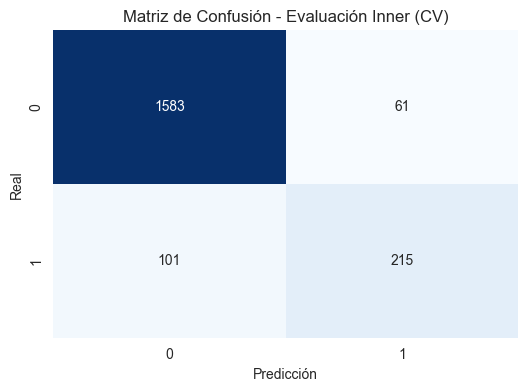

In [78]:
plt.figure(figsize=(6, 4))
sns.heatmap(inner_conf_matrix_hpo_KNN, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Evaluación Inner (CV)")
plt.show()


### KNN con HPO: tabla con los hiperparámetros optimizados

Representamos mediante una tabla los resultados obtenidos en el inner loop.

In [79]:
inner_scores_out_df = pd.concat(inner_scores_out, ignore_index=True)
inner_scores_out_df = inner_scores_out_df.sort_values(by='mean_test_score', ascending=False)

print("\nResultados Acumulados de Validación Cruzada")
display(inner_scores_out_df)


Resultados Acumulados de Validación Cruzada


,param_n_neighbors,param_weights,param_metric,param_p,mean_test_score,std_test_score,rank_test_score
15,3,distance,manhattan,3,0.821523,0.023260,1
21,6,distance,manhattan,3,0.820331,0.025178,2
17,4,distance,manhattan,3,0.819261,0.025539,3
25,2,distance,minkowski,3,0.819180,0.031500,4
19,5,distance,manhattan,3,0.818439,0.027990,5
13,2,distance,manhattan,3,0.817466,0.029627,6
1,2,distance,euclidean,3,0.813370,0.030761,7
23,7,distance,manhattan,3,0.808510,0.016052,8
3,3,distance,euclidean,3,0.805995,0.020583,9
5,4,distance,euclidean,3,0.785763,0.026190,10


Las filas de la tabla representan configuraciones de hiperpárametros ordenadas en orden descendente de balanced accuracy, con la mejor opción al principio. 

Aumentar el número de splits del KFold a 10 una mejor mean_test_score (debido a que se entrena con más datos en cada iteración), pero también incrementa la variabilidad (debido a que cada conjunto de prueba es más pequeño), por lo que hemos decidido usar 5 folds igual que en el resto de modelos.

p=3 solo es relevante para la métrica Minkowski, mientras que para Euclidean y Manhattan, el valor de p no se usa ya que por definición p=2 en Euclidean y p=1 en Manhattan.

### KNN con HPO: Gráficos de error para el estudio de los hiperparámetros

Usando los resultados acumulados de la validación cruzada en el GridSearch podemos analizar el rendimiento medio de los modelos dependiendo de los valores asignados a cada hiperparámetro

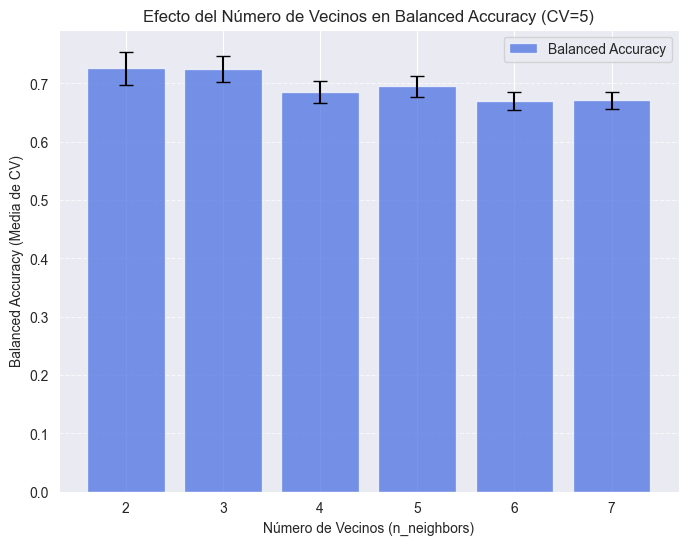

In [80]:
inner_scores_out_df = pd.concat(inner_scores_out, ignore_index=True)

grouped_scores = inner_scores_out_df.groupby('param_n_neighbors').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8,6))

plt.bar(grouped_scores['param_n_neighbors'], 
        grouped_scores['mean_balanced_accuracy'], 
        yerr=grouped_scores['std_balanced_accuracy'], 
        capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xlabel("Número de Vecinos (n_neighbors)")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto del Número de Vecinos en Balanced Accuracy (CV={inner_cv.get_n_splits()})")
plt.xticks(grouped_scores['param_n_neighbors'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()


No hay una diferencia drástica entre elegir entre diferentes números de vecinos en cuanto a Balanced Accuracy. Cabe mencionar que Cuando k es par (p. ej. 4), en un problema de clasificación binaria podría darse un empate (2-2) en la votación de los vecinos. Con un  k impar (p. ej. 5), el empate es menos probable, lo que puede resultar en un ligero beneficio en la clasificación.

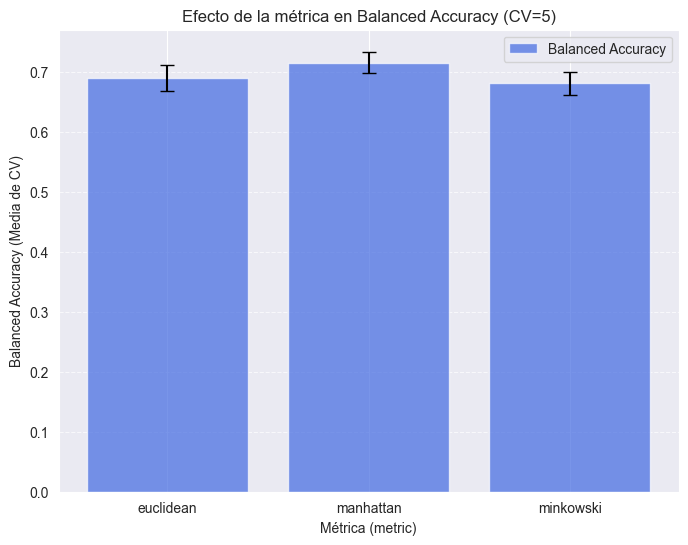

In [81]:
inner_scores_out_df = pd.concat(inner_scores_out, ignore_index=True)

grouped_scores = inner_scores_out_df.groupby('param_metric').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8,6))

plt.bar(grouped_scores['param_metric'], 
        grouped_scores['mean_balanced_accuracy'], 
        yerr=grouped_scores['std_balanced_accuracy'], 
        capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xlabel("Métrica (metric)")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto de la métrica en Balanced Accuracy (CV={inner_cv.get_n_splits()})")
plt.xticks(grouped_scores['param_metric'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()

La distancia manhattan parece ser la mejor para el hiperparámetro metric, lo que tiene sentido ya que 4 de los 5 mejores modelos usan manhattan. Euclidean y minkowski obtienen resultados muy parecidos, aunque la distancia euclídea parece ser ligeramente mejor.

### KNN con HPO: Mapa de calor

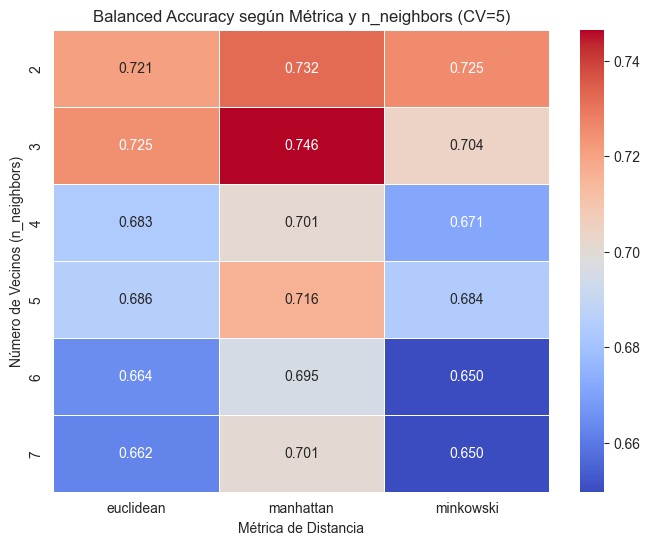

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir la lista de resultados acumulados en un DataFrame
inner_scores_out_df = pd.concat(inner_scores_out, ignore_index=True)

# Crear una tabla pivote para el heatmap (n_neighbors vs metric) mostrando mean_test_score
heatmap_data = inner_scores_out_df.pivot_table(
    index='param_n_neighbors', columns='param_metric', values='mean_test_score', aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)

plt.xlabel("Métrica de Distancia")
plt.ylabel("Número de Vecinos (n_neighbors)")
plt.title(f"Balanced Accuracy según Métrica y n_neighbors (CV={inner_cv.get_n_splits()})")

plt.show()


Aunque hay zonas “más rojas” (valores más altos), las diferencias podrían estar dentro de un margen de error si consideramos la desviación estándar de la validación cruzada.
Además, hay que tener en cuenta que el heatmap hace un promedio de la métrica (mean_test_score) para cada par (n_neighbors, metric), sin distinguir los otros hiperparámetros (weights y p) que también están presentes en el grid.
El Grid Search, en cambio, elige la mejor combinación exacta. Puede que el máximo global surja de una combinación particular de weights, n_neighbors, metric y p que no coincide con el promedio mostrado en el heatmap. 
Este es nuestro caso ya que en el heatmap vemos que la zona donde se concentran de media los mejores valores de mean_test_score tiene {'metric': 'manhattan', 'n_neighbors': 3} mientras que en el grid search la combinación óptima nos sale con los hiperparámetros {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}, que es una solución más exacta.



# Métodos básicos: Árbol de decisión

## Árbol de decisión: Entrenamiento con hiperparámetros por omisión

El clasificador DecisionTreeClassifier de scikit-learn tiene los siguientes parámetros por defecto:

- criterion='gini': función usada para evaluar la calidad de cada split
- splitter='best': estrategia para elegir el split en cada nodo
- max_depth=None: por defecto el arbol se expande hasta que las hojas contengan solo instancias de una clase o min_sample_split insatancias
- min_samples_split=2: número mínimo de instancias en un nodo para continuar haciendo separaciones
- min_samples_leaf=1: número mínimo de instancias permitido en las hojas. Si un split generaría una hoja con menos instancias no se considera realizarlo
- min_weight_fraction_leaf=0.0: porcentaje de las instancias totales que tiene que contener como mínimo cada hoja. Por defecto no se establece restricción
- max_features=None: establece cuantas columnas (variables) se tienen en cuenta para buscar el mejor split. Por defecto se consideran todas las columnas del dataset
- random_state=None: semilla de aleatoriedad para elegir el split en caso de empate en el criterio de evaluación
- max_leaf_nodes=None: número máximo de hojas en el árbol final. Por defecto no se establece restricción
- min_impurity_decrease=0.0: reducción de impuridad mínima necesaria para realizar un split en un nodo. Por defecto no se establece restricción
- class_weight=None: pesos asociados a cada clase para problemas desbalanceados. Por defecto se usan pesos de 1 para todas las clases
- ccp_alpha=0.0: valor que controla la complejidad máxima en la poda del árbol de decisión mediante Minimal Cost-Complexity Pruning
- monotonic_cst=None: no se aplican restricciones de monotonicidad por defecto

In [21]:
import time

decision_tree_default = DecisionTreeClassifier(random_state=72)  # Hiperparámetros por defecto y seed 72 para romper empates de split siempre de la misma manera

start_time = time.time()
decision_tree_default.fit(X_train_transformed, y_train)
default_time_fit_tree = time.time() - start_time
print(f"Tiempo de entrenamiento de DecisionTree default: {default_time_fit_tree:.8f} segundos")

Tiempo de entrenamiento de DecisionTree default: 0.02041340 segundos


## Métricas del DecissionTree default

In [24]:
# Utilizar cross_val_predict para obtener las predicciones mediante validación cruzada
start_time = time.time()
y_pred_cv = cross_val_predict(decision_tree_default, X_train_transformed, y_train, cv=inner_cv)
default_time_predict = time.time() - start_time

# Calcular las métricas sobre el conjunto de entrenamiento (evaluación inner)
default_balanced_accuracy_tree = balanced_accuracy_score(y_train, y_pred_cv)
default_accuracy_tree = accuracy_score(y_train, y_pred_cv)
default_conf_matrix_tree = confusion_matrix(y_train, y_pred_cv)
default_class_report_tree = classification_report(y_train, y_pred_cv, zero_division=0)

# Calcular TPR y TNR a partir de la matriz de confusión
tn, fp, fn, tp = default_conf_matrix_tree.ravel()
TPR = tp / (tp + fn)
TNR = tn / (tn + fp)

# Imprimir los resultados
print("Modelo DecisionTreeClassifier con hiperparámetros default  (evaluación inner con validación cruzada):")
print(f"Balanced Accuracy: {default_balanced_accuracy_tree:.4f}")
print(f"Accuracy: {default_accuracy_tree:.4f}")
print("\nClassification Report:")
print(default_class_report_tree)
print("Matriz de Confusión:")
print(default_conf_matrix_tree)
print(f"TPR: {TPR:.4f}")
print(f"TNR: {TNR:.4f}")
print(f"\nTiempo de entrenamiento de DecisionTreeClassifier default: {default_time_fit_tree:.8f} segundos")
print(f"Tiempo de predicción (CV) de DecisionTreeClassifier default: {default_time_predict:.8f} segundos")

Modelo DecisionTreeClassifier con hiperparámetros default  (evaluación inner con validación cruzada):
Balanced Accuracy: 0.7941
Accuracy: 0.8776

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1644
           1       0.61      0.67      0.64       316

    accuracy                           0.88      1960
   macro avg       0.77      0.79      0.78      1960
weighted avg       0.88      0.88      0.88      1960

Matriz de Confusión:
[[1508  136]
 [ 104  212]]
TPR: 0.6709
TNR: 0.9173

Tiempo de entrenamiento de DecisionTreeClassifier default: 0.02041340 segundos
Tiempo de predicción (CV) de DecisionTreeClassifier default: 0.06035686 segundos


## Visualización del DecissionTree default

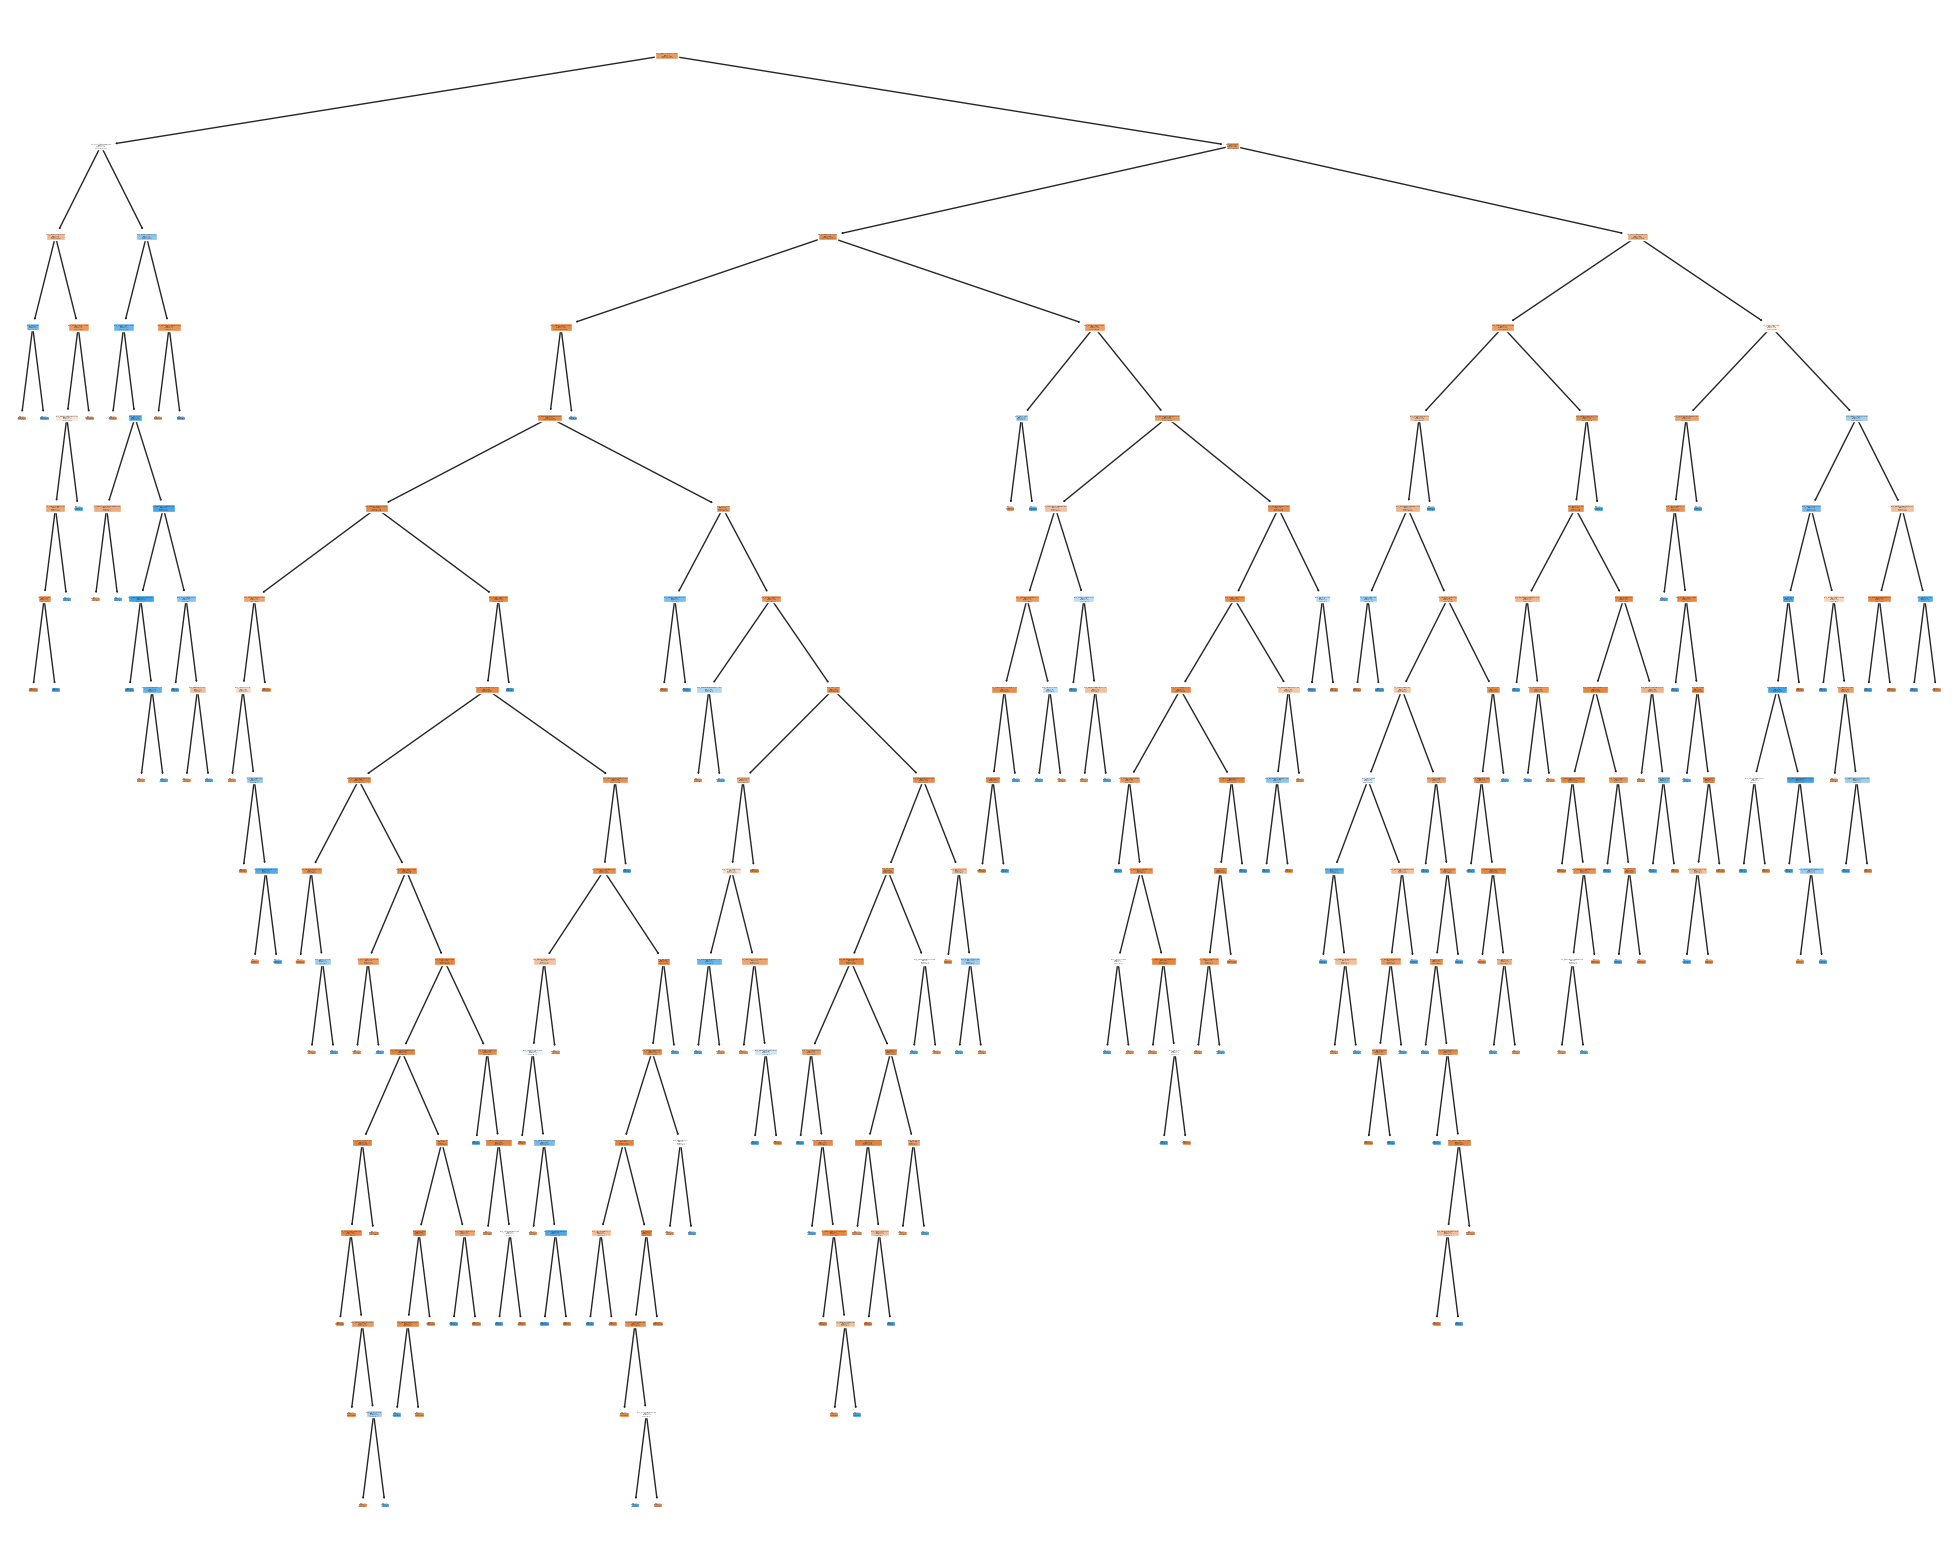

In [26]:
import matplotlib.pyplot as plt
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_default,
                   feature_names = feature_names,
                   filled=True)
# Cambiar a True para guardar la imagen en png
save_default_tree_image = False
if save_default_tree_image:
    fig.savefig("default_tree_plot.png", dpi=700, bbox_inches='tight')
    plt.close(fig)

Hemos decidido añadir la opción de guardar la imagen png del árbol para poder hacer zoom facilmente y poder ver que atributos se usan para separar en cada nivel del árbol, lo que permite interpretar el modelo. Podemos apreciar que el árbol es bastante complejo, ya que el dataset tiene un gran número de features e instancias y al tener hiperparámetro default no se limita la complejidad. Como el árbol default tiene métricas relativamente malas hemos decidido solo hacer la interpretación del árbol optimizado con HPO, que esperamos que tenga mejores resultados.

## DecisionTree: Evaluación de alternativas con ajustes de hiper-parámetros

Realizaremos una búsqueda de hiperparámetros HPO para optimizar un DecissionTreeClassifier utilizando validación cruzada interna. Hemos decidido hacer una búsqueda en rejilla bastante amplia ya que los modelos DecissionTreeClassifier tardan bastante poco en entrenarse y evaluarse y tienen rangos bastante grandes para posible valores óptimos de hiperparámetros.

In [31]:
inner_scores_out_tree = []

# Ahora entrenamos el árbol con diferentes valores para los hiperparámetros principales

# No incluimos valores menores que 10 para max_depth ya que esperamos que un los patrones de un dataset tan complejo no puedan ser capturados por un modelo tan simple (underfitting). Los valores altos dan posibilidad de overfitting, pero esperamos que la evaluación con los conjuntos de validación sea suficiente para filtrar los modelos que no generalicen suficientemente.
params_max_depth = list(range(10,20,2))
params_max_depth.append(None)   # Añadimos None para incluir los HP del árbol default en la búsqueda en caso de que sea el mejor
# Hemos decidido parar en 18 ya que valores mayores dan resultados prácticamente iguales a max_depth=18 y max_depth=None
param_grid_decision_tree = {'max_depth': params_max_depth, # Diferentes valores de profundidad máxima
              'min_samples_split': list(range(2,12,2)), # Diferentes valores de insatncias mínimas para separar un nodo
              'min_impurity_decrease': [0.0, 0.0001, 0.001, 0.01, 0.1],
              'criterion': ['gini', 'entropy', 'log_loss'], # Criterios de evaluación de los split
              'random_state': [72], # Fijamos la misma semilla para todas las combinaciones de HP
              'class_weight': ['balanced', None] # Pesos asignados a cada clase, balance usa y_train para balancear los pesos
                            } 

grid_decision_tree = GridSearchCV(
    DecisionTreeClassifier(), param_grid_decision_tree,
    cv=inner_cv, scoring='balanced_accuracy', n_jobs=-1, verbose=3
)

start_time = time.time()
grid_decision_tree.fit(X_train_transformed, y_train)
hpo_time_tree = time.time() - start_time
print(f"Hiperparámetros óptimos encontrados en {hpo_time_tree:2f}")

# Crear DataFrame con los resultados de GridSearchCV
inner_scores_df_tree = pd.DataFrame(grid_decision_tree.cv_results_)[
    ['param_max_depth', 'param_min_samples_split', 'param_criterion', 'param_class_weight', 'param_min_impurity_decrease', 
     'mean_test_score', 'std_test_score', 'rank_test_score']
]

# Añadir los resultados actuales a la lista
inner_scores_out_tree.append(inner_scores_df_tree)


Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Hiperparámetros óptimos encontrados en 12.906297


In [32]:
# Obtener el mejor modelo de árbol de decisión
best_decision_tree = grid_decision_tree.best_estimator_
start_time = time.time()
best_decision_tree.fit(X_train_transformed, y_train)
best_decision_tree_time = time.time() - start_time

print("\nHPO Decision Tree:", grid_decision_tree.best_params_)
print(f"Tiempo de entrenamiento (incluyendo HPO): {hpo_time_tree+best_decision_tree_time:.2f} segundos")
print(f"Tiempo de entrenamiento del modelo decision tree default: {default_time_fit_tree:.8f} segundos")
print(f"Mejora en el tiempo de entrenamiento del modelo default con respecto al modelo que utiliza los HP optimizados = {(hpo_time_tree+best_decision_tree_time)/default_time_fit_tree}")


HPO Decision Tree: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 18, 'min_impurity_decrease': 0.001, 'min_samples_split': 2, 'random_state': 72}
Tiempo de entrenamiento (incluyendo HPO): 12.92 segundos
Tiempo de entrenamiento del modelo decision tree default: 0.02041340 segundos
Mejora en el tiempo de entrenamiento del modelo default con respecto al modelo que utiliza los HP optimizados = 632.9301097874328


Observamos que encontrar los HP óptimos y entrenar el modelo óptimo conlleva mucho más tiempo de cómputo que entrenar el modelo utilizando los HP por defecto.
El árbol óptimo encontrado en la coss validation es bastante parecido al árbol default sin restricciones (max_depth alta, min_sample_split=2, min_impurity_decrease baja), lo que puede indicar que un modelo más complejo funcione mejor para este problema de clasificación o que la validación con 5 folds no ha sido suficiente para penalizar los modelos con overfitting.

## Visualización del DecissionTreeClassifier con hiperparámetros óptimos

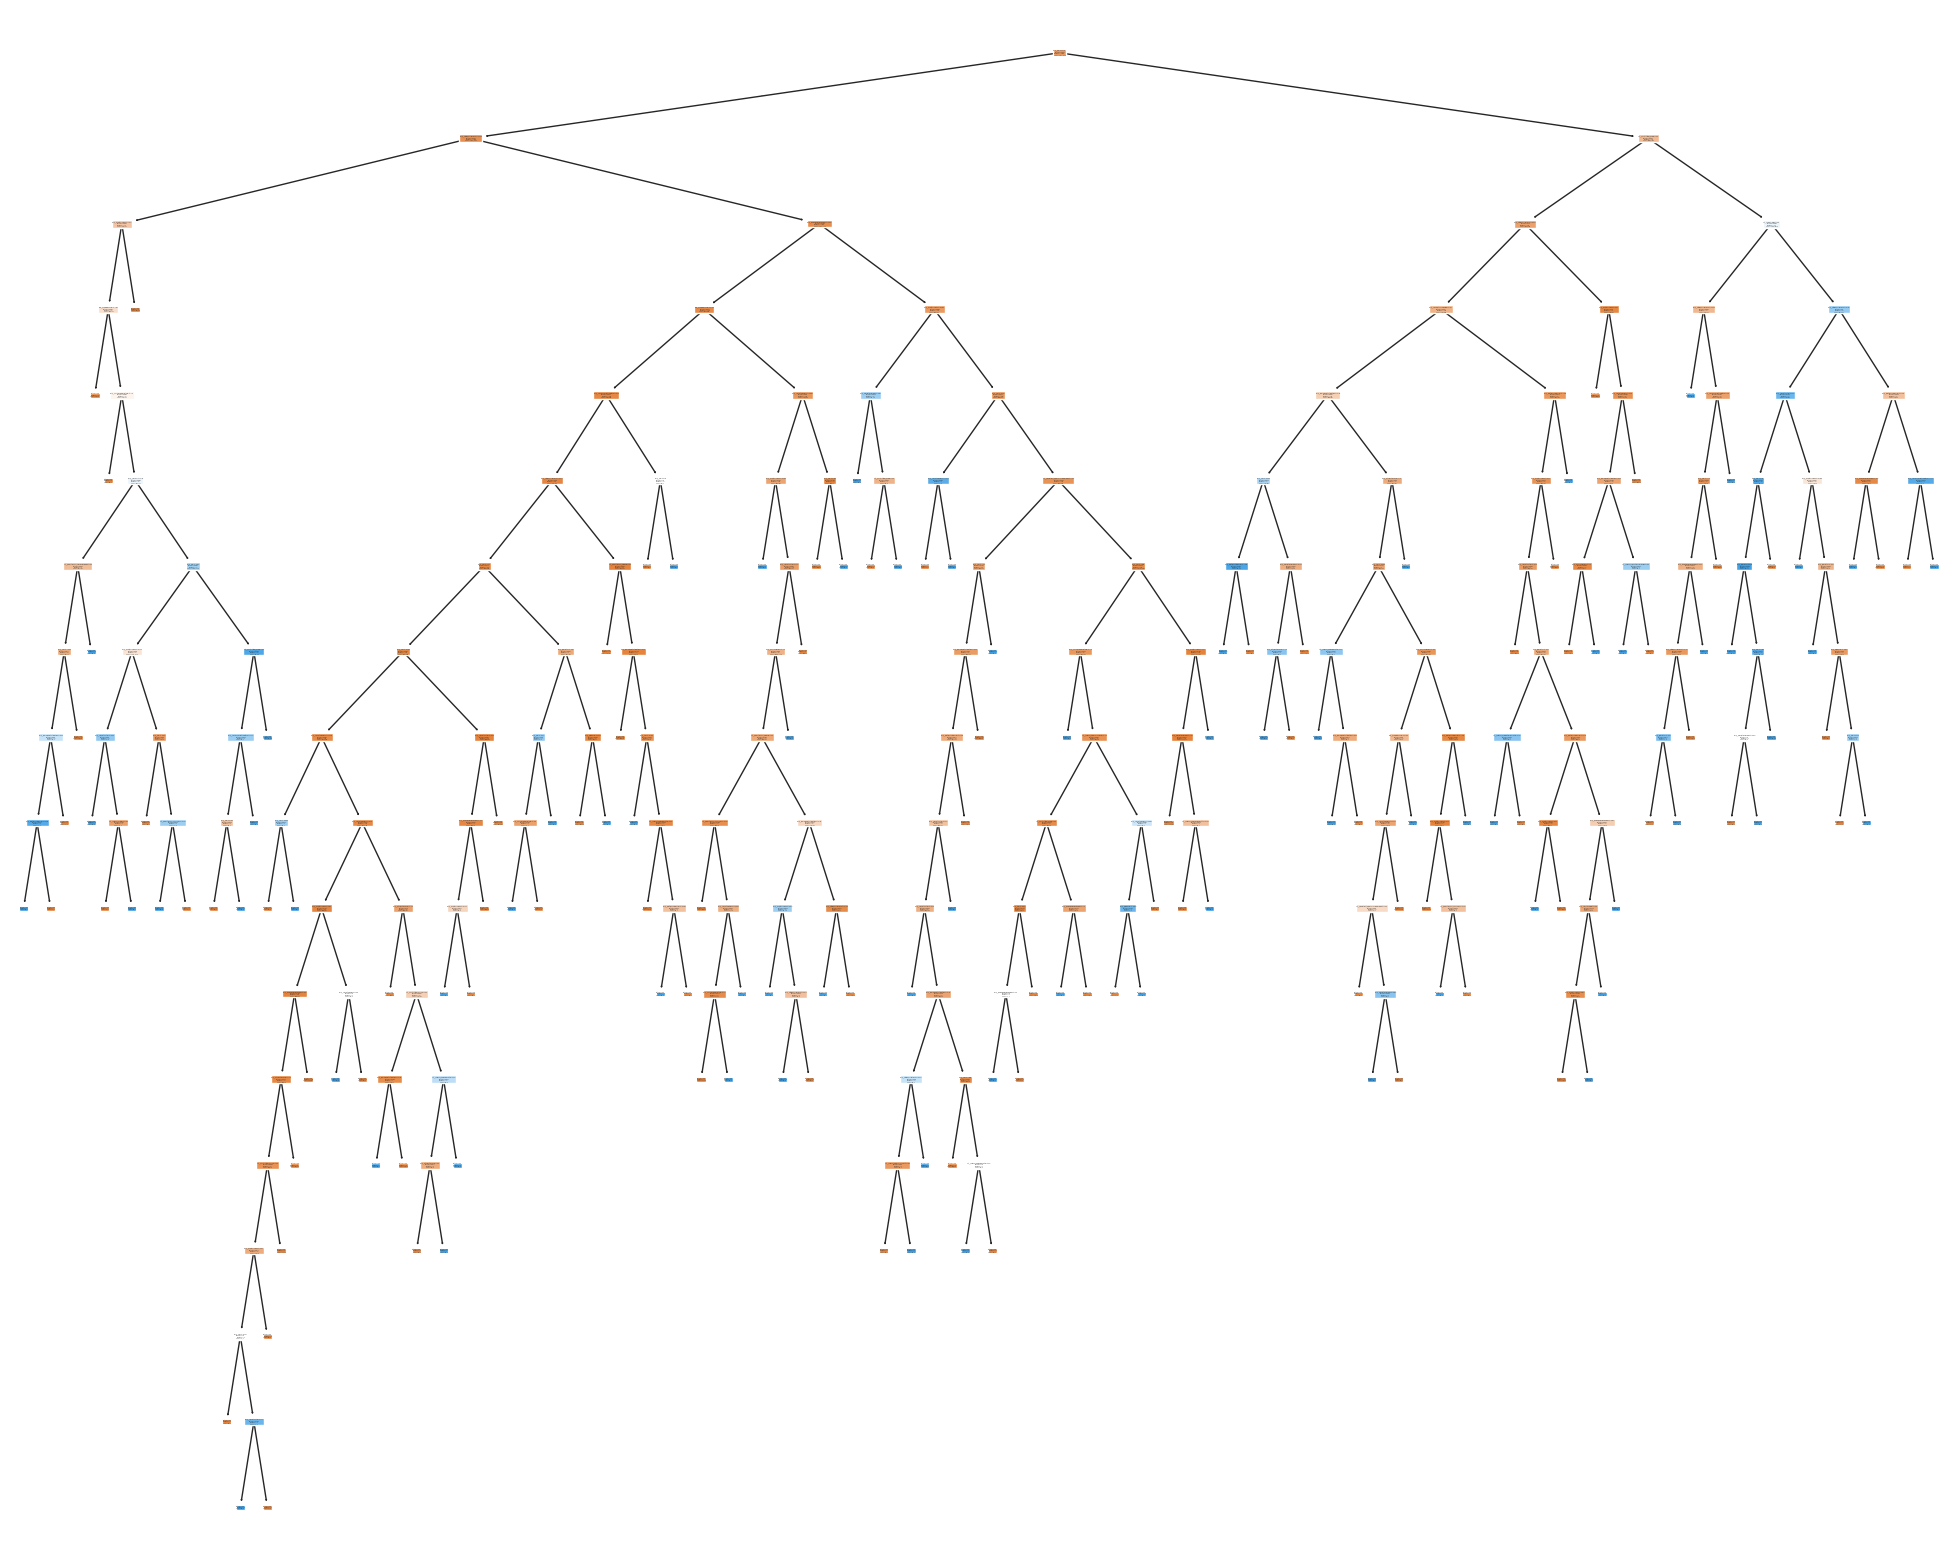

In [34]:
import matplotlib.pyplot as plt
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_decision_tree,
                   feature_names = feature_names,
                   filled=True)
# Cambiar a True para guardar la imagen en png
save_HPO_tree_image = False
if save_HPO_tree_image:
    fig.savefig("optimal_tree_plot.png", dpi=700, bbox_inches='tight')
    plt.close(fig)

Guardando la imagen en png y haciendo zoom podemos sacar las siguientes interpretaciones del árbol optimizado:
- La raiz del árbol tiene color naranja y contiene muchas más instancias de clase negativa (desbalanceo de clases), por lo que los nodos con colores naranjas más concentrados significan alta concentración de instancias negativas y los más azules alta concentración de instancias positivas.
- Los attributos usados para las separaciones en niveles altos (cercanos a la raíz) son los que menos entropía media generan en la partición y por tanto mejor separan las instancias de clases opuestas. Esto significa que generalmente cuanto más arriba esté un atributo en el árbol más relevante es para la clasificación, lo que puede indicar cierta relación más o menos fuerte entre ese atributo y la clase Attrition.
- En la raíz se hace la división por el attributo num_hrs y se puede apreciar que la mayoría de las instancias negativas acaban en el sub-árbol de la izquierda, lo que puede indicar que un número bajo de horas esta relacionado con la clase negativa.
- cat_MarritalStatus_Single se usa para dividir en el segundo nivel y la mayoría de las instancias de clase negativa acaban en la parte izquierda, lo que puede indicar que los empleados no solteros son menos propensos a el abandono/agotamiento.
- num_TotalWorkingYears también se usa para separar en el segundo y tercer nivel, dejando nodos más puros negativos a la derecha, lo que indica que con valores altos de años totales trabajados la probabilidad de abandono/agotamiento disminuye.
- num_MonthlyIncome también aparece en varios nodos en el tercer y cuarto nivel y tiende a dejar las instancias de clase negativa a la derecha lo que indica que salarios más altos reducen la probabilidad de abandono/agotamiento de los empleados.

Se puede seguir interpretando las divisiones del árbol, pero consideramos que las mencionadas arriba son los patrones más claros e importantes que presenta el árbol de decisión.

## Resultados de DecisionTree con HPO: balanced accuracy, TPR / TNR, accuracy y confusion matrix (inner)

Para evaluar internamente sin usar el conjunto de test, utilizamos la función cross_val_predict para obtener las predicciones de validación para cada muestra del conjunto de entrenamiento, y luego calcular las métricas de interés. 

Realizamos validación cruzada KFold en la que para cada iteración, el modelo se entrena con k-1 folds y se evalúa en el fold restante. En cada fold se calculan métricas como el balanced accuracy, accuracy, y se genera la matriz de confusión.

In [89]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

# Utilizar cross_val_predict para obtener las predicciones mediante validación cruzada
start_time = time.time()
y_pred_cv = cross_val_predict(best_decision_tree, X_train_transformed, y_train, cv=inner_cv)
best_time_predict = time.time() - start_time

# Calcular las métricas sobre el conjunto de entrenamiento (evaluación inner)
inner_bal_acc_hpo_tree = balanced_accuracy_score(y_train, y_pred_cv)
inner_acc_hpo_tree = accuracy_score(y_train, y_pred_cv)
inner_conf_matrix_hpo_tree = confusion_matrix(y_train, y_pred_cv)
inner_class_report_hpo_tree = classification_report(y_train, y_pred_cv, zero_division=0)

# Calcular TPR y TNR a partir de la matriz de confusión
tn, fp, fn, tp = inner_conf_matrix_hpo_tree.ravel()
TPR_hpo_tree = tp / (tp + fn)
TNR_hpo_tree = tn / (tn + fp)

# Imprimir los resultados
print("Modelo DecisionTreeClassifier con hiperparámetros optimizados (evaluación inner con validación cruzada):")
print(f"Balanced Accuracy: {inner_bal_acc_hpo_tree:.4f}")
print(f"Accuracy: {inner_acc_hpo_tree:.4f}")
print("\nClassification Report:")
print(inner_class_report_hpo_tree)
print("Matriz de Confusión:")
print(inner_conf_matrix_hpo_tree)
print(f"TPR: {TPR_hpo_tree:.4f}")
print(f"TNR: {TNR_hpo_tree:.4f}")
print(f"\nTiempo de entrenamiento de DecisionTreeClassifier óptimo: {best_decision_tree_time:.8f} segundos")
print(f"Tiempo de predicción (CV) de DecisionTreeClassifier óptimo: {best_time_predict:.8f} segundos")

Modelo DecisionTreeClassifier con hiperparámetros optimizados (evaluación inner con validación cruzada):
Balanced Accuracy: 0.8092
Accuracy: 0.8944

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1644
           1       0.67      0.68      0.68       316

    accuracy                           0.89      1960
   macro avg       0.80      0.81      0.81      1960
weighted avg       0.90      0.89      0.89      1960

Matriz de Confusión:
[[1537  107]
 [ 100  216]]
TPR: 0.6835
TNR: 0.9349

Tiempo de entrenamiento de DecisionTreeClassifier óptimo: 0.02342677 segundos
Tiempo de predicción (CV) de DecisionTreeClassifier óptimo: 0.12925363 segundos


## DecisionTree: Matriz de confusión con HPO

Vamos a visualizar la matriz de confusion del árbol de decisión en un gráfico de calor.

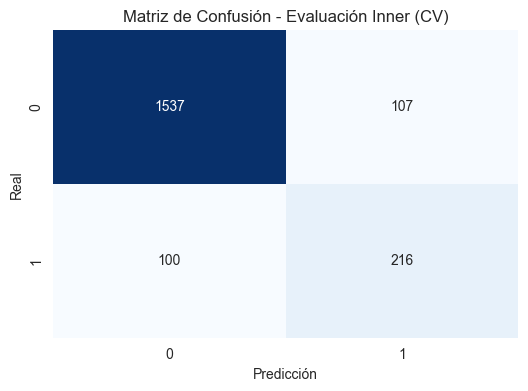

In [90]:
plt.figure(figsize=(6, 4))
sns.heatmap(inner_conf_matrix_hpo_tree, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Evaluación Inner (CV)")
plt.show()

### DecisionTree con HPO: tabla con los hiperparámetros optimizados

Representamos mediante una tabla los resultados obtenidos en el inner loop.

In [91]:
inner_scores_out_df_tree = pd.concat(inner_scores_out_tree, ignore_index=True)
inner_scores_out_df_tree = inner_scores_out_df_tree.sort_values(by='mean_test_score', ascending=False)

print("\nResultados Acumulados de Validación Cruzada")
display(inner_scores_out_df_tree)


Resultados Acumulados de Validación Cruzada


,param_max_depth,param_min_samples_split,param_criterion,param_class_weight,param_min_impurity_decrease,mean_test_score,std_test_score,rank_test_score
860,18,2,log_loss,None,0.001,0.809151,0.034738,1
885,None,2,log_loss,None,0.001,0.809151,0.034738,1
710,18,2,entropy,None,0.001,0.809151,0.034738,1
735,None,2,entropy,None,0.001,0.809151,0.034738,1
875,None,2,log_loss,None,0.000,0.808239,0.034402,5
...,...,...,...,...,...,...,...,...
21,10,4,gini,balanced,0.100,0.500000,0.000000,721
20,10,2,gini,balanced,0.100,0.500000,0.000000,721
899,None,10,log_loss,None,0.100,0.500000,0.000000,721
895,None,2,log_loss,None,0.100,0.500000,0.000000,721


Podemos ver que hay un empate entre los 4 mejores modelos y que la única diferencia entre ellos son los HP max_depth=18/None y criterion=log_loss/entropy. Esto indica que ambos valores para estos dos hiperparámetros resultan en modelos equivalentes con nuestro conjunto de entrenamiento, por lo que podemos elegir cualquiera de los 4 modelos y esperar rendimientos muy similares.

### DecissionTree con HPO: Gráficos de error para el estudio de los hiperparámetros

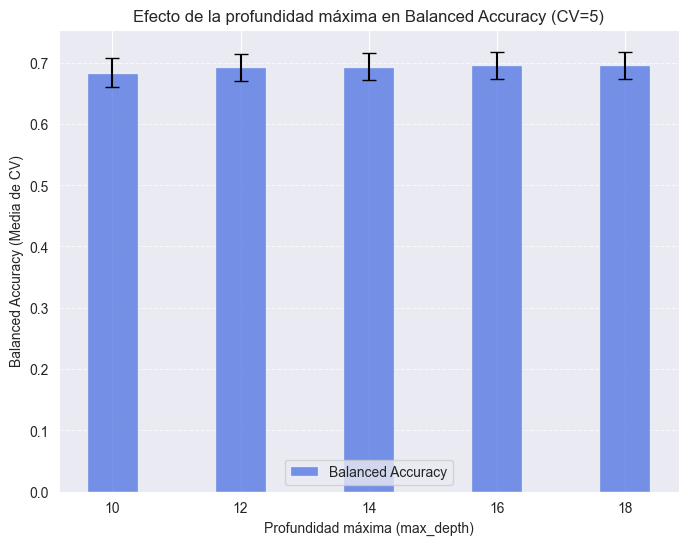

In [92]:
inner_scores_out_df_tree = pd.concat(inner_scores_out_tree, ignore_index=True)

grouped_scores_tree_max_depth = inner_scores_out_df_tree.groupby('param_max_depth').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8,6))

plt.bar(grouped_scores_tree_max_depth['param_max_depth'], 
        grouped_scores_tree_max_depth['mean_balanced_accuracy'], 
        yerr=grouped_scores_tree_max_depth['std_balanced_accuracy'], 
        capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xlabel("Profundidad máxima (max_depth)")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto de la profundidad máxima en Balanced Accuracy (CV={inner_cv.get_n_splits()})")
plt.xticks(grouped_scores_tree_max_depth['param_max_depth'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()

Podemos ver que el efecto de max_depth en balanced_acc es muy leve aunque los modelos con valores altos (más complicados) son un poco mejores que valores bajos como 10. Esto puede indicar que el problema de clasificación no es tan sensible al overfitting y que una habilidad de generalización amplia no es tan necesaria para obtener clasificaciónes precisas.

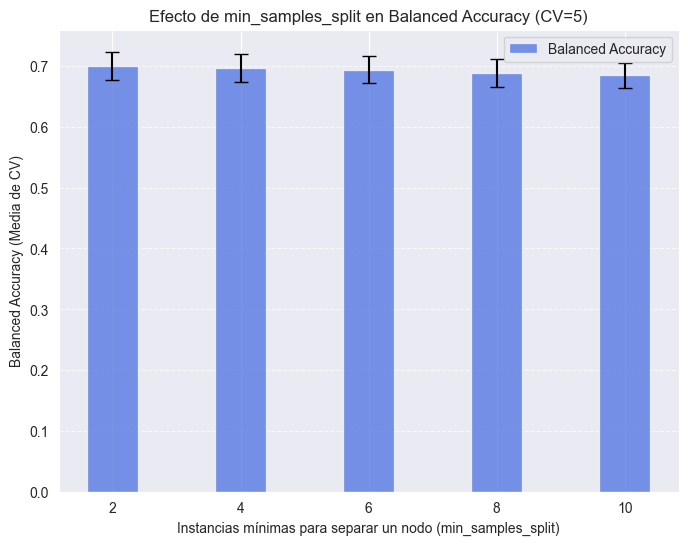

In [93]:
grouped_scores_tree_min_samples_split = inner_scores_out_df_tree.groupby('param_min_samples_split').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8,6))

plt.bar(grouped_scores_tree_min_samples_split['param_min_samples_split'], 
        grouped_scores_tree_min_samples_split['mean_balanced_accuracy'], 
        yerr=grouped_scores_tree_min_samples_split['std_balanced_accuracy'], 
        capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xlabel("Instancias mínimas para separar un nodo (min_samples_split)")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto de min_samples_split en Balanced Accuracy (CV={inner_cv.get_n_splits()})")
plt.xticks(grouped_scores_tree_min_samples_split['param_min_samples_split'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()

De nuevo, los modelos menos complejos (min_sample_split mayor) tienden a obtener resultados un poco peores, pero por márgenes muy pequeños. Esto nos da aun más indicios de que el problema no es sensible al overfitting y que los modelos simples no proporcionan ventajas.

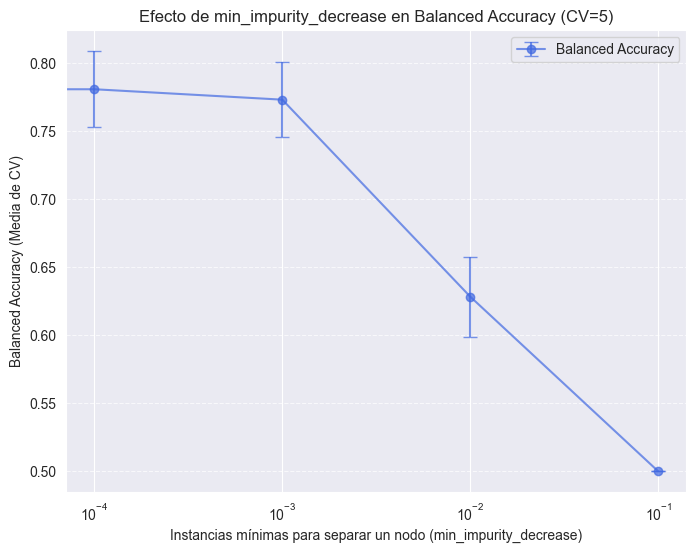

In [94]:
grouped_scores_tree_min_impurity_decrease = inner_scores_out_df_tree.groupby('param_min_impurity_decrease').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8, 6))

# Usamos plt.errorbar en vez de plt.bar porque facilita la representación de gráficos de error en escala logarítmica
plt.errorbar(grouped_scores_tree_min_impurity_decrease['param_min_impurity_decrease'],
             grouped_scores_tree_min_impurity_decrease['mean_balanced_accuracy'],
             yerr=grouped_scores_tree_min_impurity_decrease['std_balanced_accuracy'],
             fmt='o-', capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xscale('log')
plt.xlabel("Instancias mínimas para separar un nodo (min_impurity_decrease)")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto de min_impurity_decrease en Balanced Accuracy (CV={inner_cv.get_n_splits()})")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()


Otra vez más los modelos más simples (min_impurity_decrease alta) obtienen resultados peores, aunque en este caso las diferencias de balanced_accuracy son bastante más grandes, posiblemente porque valores altos de este HP simplifican drasticamente el modelo.

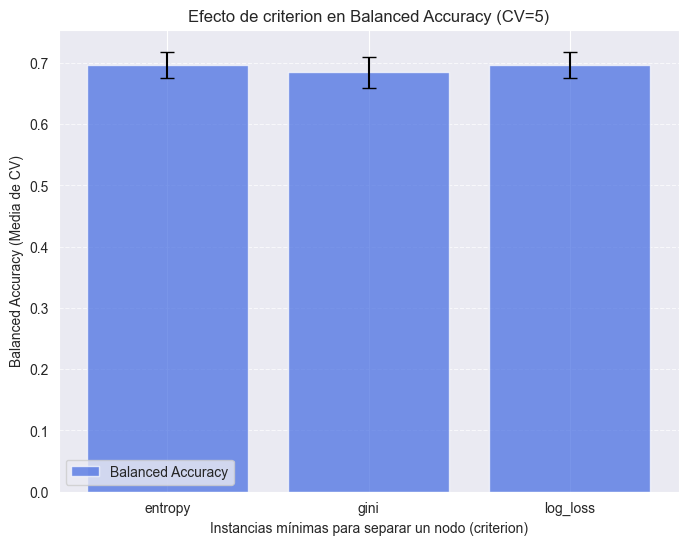

In [95]:
grouped_scores_tree_criterion = inner_scores_out_df_tree.groupby('param_criterion').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8, 6))

plt.bar(grouped_scores_tree_criterion['param_criterion'],
        grouped_scores_tree_criterion['mean_balanced_accuracy'],
        yerr=grouped_scores_tree_criterion['std_balanced_accuracy'],
        capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xlabel("Instancias mínimas para separar un nodo (criterion)")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto de criterion en Balanced Accuracy (CV={inner_cv.get_n_splits()})")
plt.xticks(grouped_scores_tree_criterion['param_criterion'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()

Las diferencias entre los criterios de separación son muy pequeñas, pero si se puede apreciar que gini es algo peor que entropy y log_loss y que estas dos son practicamente equivalentes.

### DecisionTree con HPO: Mapa de calor

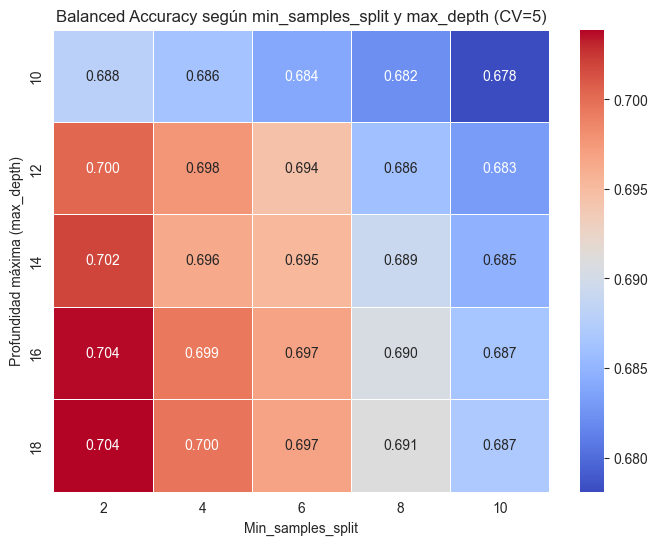

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir la lista de resultados acumulados en un DataFrame
inner_scores_out_df_tree = pd.concat(inner_scores_out_tree, ignore_index=True)

# Crear una tabla pivote para el heatmap (max_depth vs min_samples_split) mostrando mean_test_score
heatmap_data_tree = inner_scores_out_df_tree.pivot_table(
    index='param_max_depth', columns='param_min_samples_split', values='mean_test_score', aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data_tree, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)

plt.xlabel("Min_samples_split")
plt.ylabel("Profundidad máxima (max_depth)")
plt.title(f"Balanced Accuracy según min_samples_split y max_depth (CV={inner_cv.get_n_splits()})")

plt.show()

Podemos ver que la concentración de los mejores modelos se encuentra en valores bajos de min_samples_split y valores altos de max_depth. Min_samples_split=2 es claramente el mejor valor y los valores 16 y 18 de max_depth dan resultados prácticamente iguales. Estos resultados son coherentes con el modelo óptimo encontrado en en grid search. 

# Modelos Lineales: Regresión Logística

## Regresión logística SIN regularización (default)
### Entrenamiento

In [36]:
from sklearn.linear_model import LogisticRegression

logreg_default = LogisticRegression(penalty=None, random_state=72)

start = time.time()
logreg_default.fit(X_train_transformed, y_train)
default_time = time.time() - start

print("Tiempo de entrenamiento de regresión logística SIN regularización (default): {:.4f} segundos".format(default_time))

Tiempo de entrenamiento de regresión logística SIN regularización (default): 0.0525 segundos


### Métricas default sin regularización: balanced accuracy, TPR, TNR, accuracy y confusion matrix (inner)

Evaluación Inner para Logistic Regression SIN regularización (default):
Balanced Accuracy: 0.6223
Accuracy: 0.8531
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1644
           1       0.59      0.28      0.38       316

    accuracy                           0.85      1960
   macro avg       0.73      0.62      0.65      1960
weighted avg       0.83      0.85      0.83      1960

Matriz de Confusión:
[[1583   61]
 [ 227   89]]
TPR: 0.2816
TNR: 0.9629


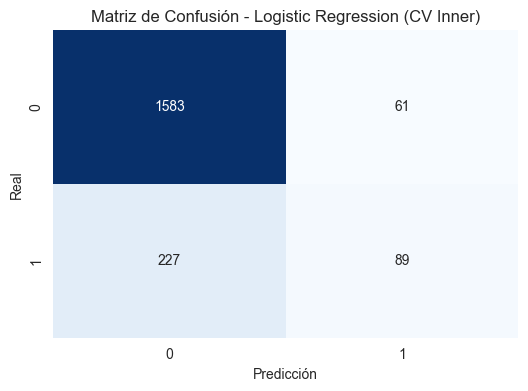

In [37]:
# Evaluación Inner: predicciones mediante validación cruzada sobre el conjunto de entrenamiento.
y_pred_cv_logreg = cross_val_predict(logreg_default, X_train_transformed, y_train, cv=inner_cv)

# Calcular métricas usando los datos de entrenamiento
inner_bal_acc_logreg = balanced_accuracy_score(y_train, y_pred_cv_logreg)
inner_acc_logreg = accuracy_score(y_train, y_pred_cv_logreg)
inner_conf_matrix_logreg = confusion_matrix(y_train, y_pred_cv_logreg)
inner_class_report_logreg = classification_report(y_train, y_pred_cv_logreg)

print("Evaluación Inner para Logistic Regression SIN regularización (default):")
print("Balanced Accuracy: {:.4f}".format(inner_bal_acc_logreg))
print("Accuracy: {:.4f}".format(inner_acc_logreg))
print("Classification Report:")
print(inner_class_report_logreg)
print("Matriz de Confusión:")
print(inner_conf_matrix_logreg)

# Calcular TPR y TNR
tn, fp, fn, tp = inner_conf_matrix_logreg.ravel()
TPR_logreg = tp / (tp + fn)
TNR_logreg = tn / (tn + fp)
print("TPR: {:.4f}".format(TPR_logreg))
print("TNR: {:.4f}".format(TNR_logreg))

# Visualizar la matriz de confusión como un heatmap.
plt.figure(figsize=(6, 4))
sns.heatmap(inner_conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Logistic Regression (CV Inner)")
plt.show()


## Regresión logística con regularización l1 default

### Entrenamiento

In [38]:
logreg_l1_default = LogisticRegression(penalty='l1', solver='liblinear', random_state=72)

start_default = time.time()
logreg_l1_default.fit(X_train_transformed, y_train)
default_time_fit = time.time() - start_default
print("Tiempo de entrenamiento Logistic Regression L1 default: {:.4f} segundos".format(default_time_fit))


Tiempo de entrenamiento Logistic Regression L1 default: 0.0525 segundos


### Resultados de Log Reg L1 default: balanced accuracy, TPR / TNR, accuracy y confusion matrix (inner)

Evaluación Inner para Logistic Regression L1 default:
Balanced Accuracy: 0.6231
Accuracy: 0.8566
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1644
           1       0.62      0.28      0.39       316

    accuracy                           0.86      1960
   macro avg       0.75      0.62      0.65      1960
weighted avg       0.83      0.86      0.83      1960

Matriz de Confusión:
[[1591   53]
 [ 228   88]]
TPR: 0.2785
TNR: 0.9678


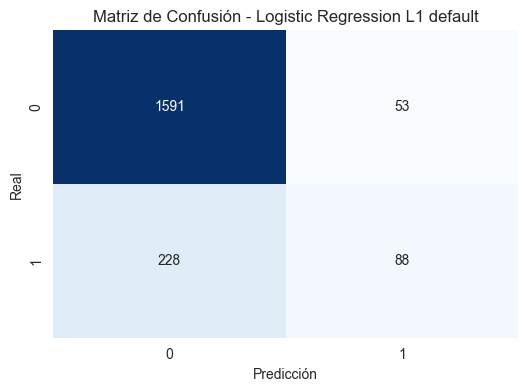

In [39]:
# Evaluación Inner: predicciones mediante validación cruzada
y_pred_cv_logreg_l1 = cross_val_predict(logreg_l1_default, X_train_transformed, y_train, cv=inner_cv)

# Calcular métricas en el conjunto de entrenamiento (evaluación inner)
inner_bal_acc_logreg_l1 = balanced_accuracy_score(y_train, y_pred_cv_logreg_l1)
inner_acc_logreg_l1 = accuracy_score(y_train, y_pred_cv_logreg_l1)
inner_conf_matrix_logreg_l1 = confusion_matrix(y_train, y_pred_cv_logreg_l1)
inner_class_report_logreg_l1 = classification_report(y_train, y_pred_cv_logreg_l1)

print("Evaluación Inner para Logistic Regression L1 default:")
print("Balanced Accuracy: {:.4f}".format(inner_bal_acc_logreg_l1))
print("Accuracy: {:.4f}".format(inner_acc_logreg_l1))
print("Classification Report:")
print(inner_class_report_logreg_l1)
print("Matriz de Confusión:")
print(inner_conf_matrix_logreg_l1)

# Calcular TPR y TNR a partir de la matriz de confusión
tn, fp, fn, tp = inner_conf_matrix_logreg_l1.ravel()
TPR_logreg_l1 = tp / (tp + fn)
TNR_logreg_l1 = tn / (tn + fp)
print("TPR: {:.4f}".format(TPR_logreg_l1))
print("TNR: {:.4f}".format(TNR_logreg_l1))

# Visualizar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(inner_conf_matrix_logreg_l1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Logistic Regression L1 default")
plt.show()


Las métricas de los modelos default con y sin reulación l1 son muy similares, pero como la balanced accuracy de el modelo con regularización l1 es ligeramente mejor que sin regularización (0.6231 vs 0.6223), hemos decidido hacer búsqueda de hiperparámetros de modelos con L1.

## Regresión logística con regularización L1 optimizada (HPO)
### INNER LOOP de Regresión logística L1 HPO 

In [46]:
logreg_l1_hpo = LogisticRegression(penalty='l1', max_iter=1000, random_state=72)

# Definimos el grid de hiperparámetros a optimizar
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],                # Fuerza de regularización (inverso), es el HP más importante
    'solver': ['liblinear', 'saga'],             # Algoritmo de optimización compatible con L1
    'class_weight': [None, 'balanced'],          # Ajustar pesos para contrarrestar el desbalanceo
    'tol': [1e-4, 1e-3, 1e-2]                     # Tolerancia para la convergencia
}

# GridSearchCV para la HPO
grid_search_l1 = GridSearchCV(
    logreg_l1_hpo,
    param_grid,
    cv=inner_cv,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

# Medimos el tiempo de entrenamiento con HPO
start_hpo = time.time()
grid_search_l1.fit(X_train_transformed, y_train)
hpo_time_logreg_l1 = time.time() - start_hpo

# Extraer los resultados en un dataframe
results_df = pd.DataFrame(grid_search_l1.cv_results_)

# Seleccionar columnas 
results_df = results_df[
    ['param_C', 'param_solver', 'param_class_weight', 'param_tol', 
     'mean_test_score', 'std_test_score', 'rank_test_score']
]

# Ordenar por el mejor Balanced Accuracy
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# Mostrar el DataFrame ordenado
display(results_df)

print("Mejor hiperparámetros encontrados para modelo de regresión logística con regularización L1:")
print(grid_search_l1.best_params_)
print("Mejor Balanced Accuracy (CV):", grid_search_l1.best_score_)
print(f"\nTiempo de entrenamiento (HPO) en el conjunto de entrenamiento: {hpo_time_logreg_l1:.4f} segundos")



Fitting 5 folds for each of 60 candidates, totalling 300 fits


,param_C,param_solver,param_class_weight,param_tol,mean_test_score,std_test_score,rank_test_score
23,0.10,saga,balanced,0.0100,0.727940,0.012236,1
22,0.10,saga,balanced,0.0010,0.727636,0.012807,2
21,0.10,saga,balanced,0.0001,0.726074,0.011716,3
18,0.10,liblinear,balanced,0.0001,0.723421,0.015025,4
19,0.10,liblinear,balanced,0.0010,0.723117,0.014870,5
20,0.10,liblinear,balanced,0.0100,0.722813,0.014738,6
46,10.00,saga,balanced,0.0010,0.722278,0.027346,7
58,100.00,saga,balanced,0.0010,0.722278,0.026596,8
56,100.00,liblinear,balanced,0.0100,0.721974,0.026754,9
45,10.00,saga,balanced,0.0001,0.721974,0.026700,9


Mejor hiperparámetros encontrados para modelo de regresión logística con regularización L1:
{'C': 0.1, 'class_weight': 'balanced', 'solver': 'saga', 'tol': 0.01}
Mejor Balanced Accuracy (CV): 0.7279401528817718

Tiempo de entrenamiento (HPO) en el conjunto de entrenamiento: 7.7651 segundos


In [41]:
# Obtener el mejor modelo obtenido en HPO
best_logreg_l1 = grid_search_l1.best_estimator_

# Medir el tiempo de entrenamiento del mejor modelo sobre todo el conjunto de entrenamiento
start_best = time.time()
best_logreg_l1.fit(X_train_transformed, y_train)
best_logreg_l1_time = time.time() - start_best

# Tiempo total del proceso optimizado (HPO + entrenamiento del mejor modelo)
total_hpo_time_logreg_l1 = hpo_time_logreg_l1 + best_logreg_l1_time

print("Tiempo de entrenamiento del modelo default: {:.8f} segundos".format(default_time_fit))
print("Tiempo de entrenamiento del proceso HPO (grid search): {:.4f} segundos".format(hpo_time_logreg_l1))
print("Tiempo de entrenamiento del best_logreg_l1: {:.4f} segundos".format(best_logreg_l1_time))
print("Tiempo total (HPO + entrenamiento del best modelo): {:.4f} segundos".format(total_hpo_time_logreg_l1))

# Calcular la mejora en el tiempo de entrenamiento comparando el total optimizado con el default
mejora_tiempo = total_hpo_time_logreg_l1 / default_time_fit
print("Factor de incremento en tiempo que supone la HPO y el entrenamiento del mejor modelo vs el default = {:.4f}".format(mejora_tiempo))


Tiempo de entrenamiento del modelo default: 0.05247068 segundos
Tiempo de entrenamiento del proceso HPO (grid search): 13.6847 segundos
Tiempo de entrenamiento del best_logreg_l1: 0.0163 segundos
Tiempo total (HPO + entrenamiento del best modelo): 13.7010 segundos
Factor de incremento en tiempo que supone la HPO y el entrenamiento del mejor modelo vs el default = 261.1164


## Log reg L1 con HPO: Gráficos de error para el estudio de los hiperparámetros

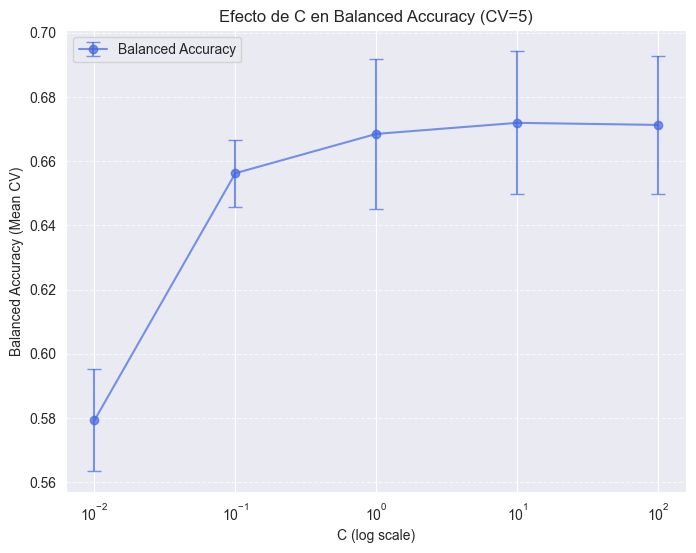

In [42]:
results_df_param_C = results_df.groupby('param_C').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8, 6))

# Usamos plt.errorbar en vez de plt.bar porque facilita la representación de gráficos de error en escala logarítmica
plt.errorbar(results_df_param_C['param_C'],
             results_df_param_C['mean_balanced_accuracy'],
             yerr=results_df_param_C['std_balanced_accuracy'],
             fmt='o-', capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xscale('log')
plt.xlabel("C (log scale)")
plt.ylabel("Balanced Accuracy (Mean CV)")
plt.title(f"Efecto de C en Balanced Accuracy (CV={inner_cv.get_n_splits()})")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()


Vemos que valores bajos de C (inversa del poder de la regularización) resultan en modelos peores, lo que podría indicar que los modelos con mucha regularización de coeficientes (modelos más simples) tienden a funcionar peor para este problema, de forma similar a los resultados vistos en los árboles de decisión. Nos hemos fijado que pese a que C=0.1 obtiene resultados peores que valores más altos, los 6 mejores modelos del ranking usan este valor, lo que resulta extraño. Después de analizar más la tabla de resultados hemos podido ver que los modelos con C=0.1 y class_weight=balanced eran mejores que el resto, pero la combinación de C=0.1 y class_weight=None daban resultados muy malos que acababan abajo del ranking, lo que explica porque de media C=0.1 no aparece como el mejor valor.

Esta interacción entre los hiperparámetros C y class_weight se puede apreciar en el siguiente mapa de calor:

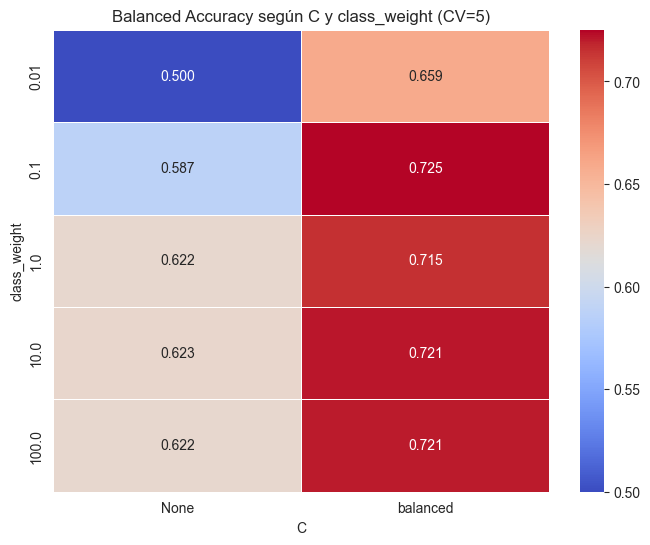

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Hace falta convertir None a la string "None" para que seaborn y matplotlib reconozca las filas con valor None
results_df['param_class_weight'] = results_df['param_class_weight'].apply(lambda x: str(x) if x is not None else "None")

# Crear una tabla pivote para el heatmap (C vs class_weight) mostrando mean_test_score
heatmap_data_tree = results_df.pivot_table(
    index='param_C', columns='param_class_weight', values='mean_test_score', aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data_tree, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)

plt.xlabel("C")
plt.ylabel("class_weight")
plt.title(f"Balanced Accuracy según C y class_weight (CV={inner_cv.get_n_splits()})")

plt.show()

Cabe destacar que no hemos incluido los gráficos de error para param_tol y param_solver ya que no mostraban resultados relevantes (el rendimento de los modelos era el mismo para cada posible valor de los hiperparámetros)

### Resultados de Log Reg L1 con HPO: balanced accuracy, TPR / TNR, accuracy y confusion matrix (inner)


Evaluación Inner para Logistic Regression L1 optimizada (HPO):
Balanced Accuracy (CV): 0.7280
Accuracy: 0.7281

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.73      0.82      1644
           1       0.34      0.73      0.46       316

    accuracy                           0.73      1960
   macro avg       0.64      0.73      0.64      1960
weighted avg       0.84      0.73      0.76      1960

Matriz de Confusión:
[[1197  447]
 [  86  230]]
TPR: 0.7278
TNR: 0.7281


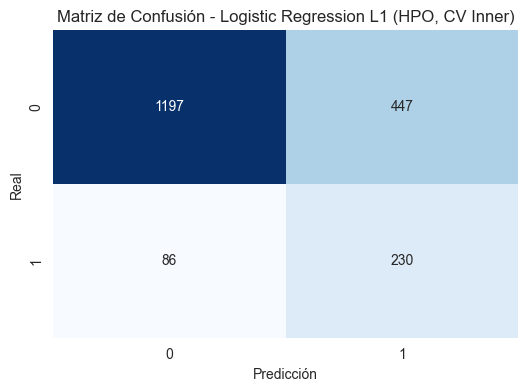

In [104]:
# Extraemos el modelo optimizado
best_logreg_l1 = grid_search_l1.best_estimator_

# Usamos cross_val_predict para obtener las predicciones en validación cruzada
y_pred_cv_hpo_logreg_l1 = cross_val_predict(best_logreg_l1, X_train_transformed, y_train, cv=inner_cv)

# Calcular las métricas en el conjunto de entrenamiento
inner_bal_acc_hpo_logreg_l1 = balanced_accuracy_score(y_train, y_pred_cv_hpo_logreg_l1)
inner_acc_hpo_logreg_l1 = accuracy_score(y_train, y_pred_cv_hpo_logreg_l1)
inner_class_report_hpo_logreg_l1 = classification_report(y_train, y_pred_cv_hpo_logreg_l1, zero_division=0)

print("Evaluación Inner para Logistic Regression L1 optimizada (HPO):")
print(f"Balanced Accuracy (CV): {inner_bal_acc_hpo_logreg_l1:.4f}")
print(f"Accuracy: {inner_acc_hpo_logreg_l1:.4f}")
print("\nClassification Report:\n", inner_class_report_hpo_logreg_l1)

# Calcular la matriz de confusión
inner_conf_matrix_hpo_logreg_l1 = confusion_matrix(y_train, y_pred_cv_hpo_logreg_l1)
print("Matriz de Confusión:")
print(inner_conf_matrix_hpo_logreg_l1)

# Calcular TPR y TNR
tn, fp, fn, tp = inner_conf_matrix_hpo_logreg_l1.ravel()
TPR_hpo_logreg_l1 = tp / (tp + fn)
TNR_hpo_logreg_l1 = tn / (tn + fp)
print(f"TPR: {TPR_hpo_logreg_l1:.4f}")
print(f"TNR: {TNR_hpo_logreg_l1:.4f}")

# Visualizar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(inner_conf_matrix_hpo_logreg_l1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Logistic Regression L1 (HPO, CV Inner)")
plt.show()

### Extracción de atributos más relevantes

In [105]:
import numpy as np

# Extraer la importancia de las características (coeficientes) del modelo L1 optimizado
# La regularización L1 tiende a poner a cero coeficientes de variables menos importantes.
coefficients = best_logreg_l1.coef_.flatten()
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
}).sort_values(by='Absolute Coefficient', ascending=False)

print("\nImportancia de las características (coeficientes) del modelo L1 optimizado:")
display(importance_df)


Importancia de las características (coeficientes) del modelo L1 optimizado:


,Feature,Coefficient,Absolute Coefficient
37,cat__MaritalStatus_Single,1.030897,1.030897
19,num__YearsWithCurrManager,-0.776240,0.776240
0,num__hrs,0.641991,0.641991
31,cat__JobRole_Manufacturing Director,-0.575929,0.575929
5,num__JobSatisfaction,-0.520326,0.520326
15,num__TotalWorkingYears,-0.510260,0.510260
4,num__EnvironmentSatisfaction,-0.456371,0.456371
38,ord__BusinessTravel,0.429984,0.429984
6,num__WorkLifeBalance,-0.335479,0.335479
18,num__YearsSinceLastPromotion,0.320001,0.320001


Podemos visualizar estos coeficientes usando seaborn y matplotlib

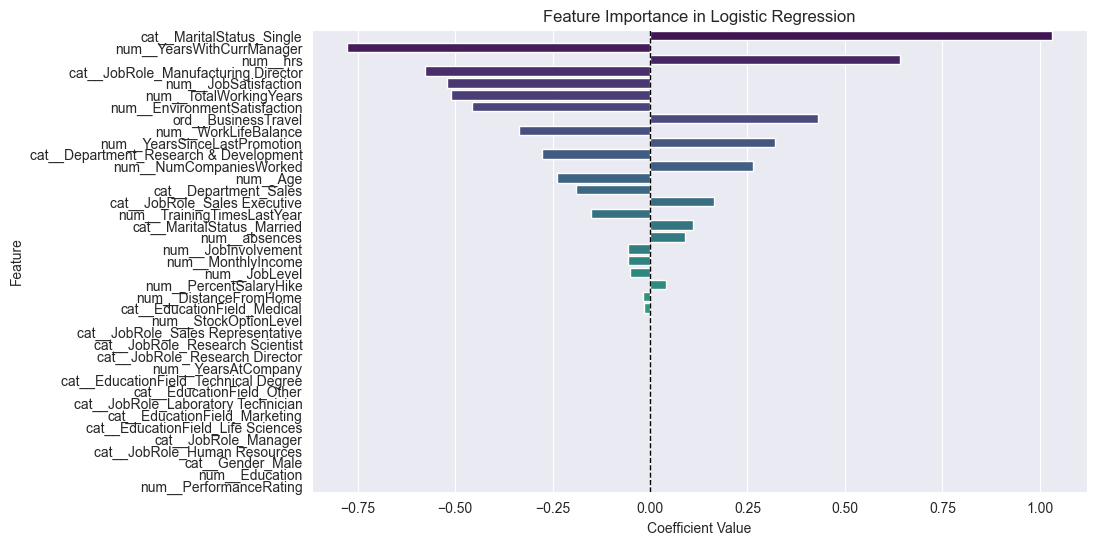

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ordenamos los coeficientes por valor absoluto para una mejor visualización
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_features = np.array(feature_names)[sorted_indices]
sorted_coefficients = coefficients[sorted_indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_coefficients, y=sorted_features, hue=sorted_features, palette="viridis", legend=False)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance in Logistic Regression")
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)  # Vertical en 0
plt.show()

A partir del gráfico de coeficientes de arriba podemos decir lo siguiente:
- Los coeficientes grandes (positivos o negativos) indican mayor influencia. Los coeficientes positivos (barras a la derecha del cero) incrementan la probabilidad de que el modelo prediga la clase positiva (abandono) mientras que los coeficientes negativos (barras a la izquierda del cero) incrementan la probabilidad de predecir la clase negativa (no abandono).
- Vemos que hrs (horas trabajadas) destaca con un coeficiente positivo y de gran magnitud. Esto sugiere que cuantas más horas trabaja el empleado, mayor es la tendencia del modelo a clasificarlo como en riesgo de abandonar

Las variables con mayores coeficientes positivos (mayor propensión a abandonar) en orden descendente de influencia son:
- Número de horas: cuantas más horas, mayor riesgo de burnout
- Ser soltero/a: puede correlacionarse con una mayor flexibilidad para cambiar de empleo
- Número de años desde el último ascenso: un largo periodo sin ascenso puede generar desmotivación o sensación de estancamiento.
- Número de compañías trabajadas: cuantas más empresas previas, mayor predisposición a cambiar de trabajo e ir rotando.
- Business Travel: los viajes frecuentes pueden incrementar el estrés y el agotamiento, favoreciendo el burnout.
- Estado civil casado (married): resulta algo contraintuitivo frente al caso anterior (soltero/a), pero podría deberse a temas personales como que las obligaciones familiares incrementan el estrés.
- Rol de sales executive: pueden implicar alta presión de objetivos y cuotas, aumentando el riesgo de burnout.

Por otro lado, las variables con coeficientes más negativos (incrementan la probabilidad de NO abandono) en orden descendente de influencia son:
- Years with current manager: tener más años con el mismo mánager puede crear una relación de confianza y mejor comunicación, lo que reduce la inclinación a abandonar.
- Total working years: empleados con más años de experiencia laboral suelen tener puestos más estables.
- Job satisfaction: mayor satisfacción, menor necesidad de buscar nuevas oportunidades.
- Work-life balance: disminuye el estrés y la fatiga, previniendo el burnout.
- Job role manufacturing director: puede que este puesto tenga mayor autonomía o remuneración.
- Environment satisfaction: un ambiente de trabajo agradable fomenta la permanencia, obviamente.
- Age: a medida que las personas avanzan en edad, suelen tener menos incentivos para cambiar de empleo.



## Log Reg L1 con HPO: Análisis de la curva ROC

Otra forma interesante de visualizar las probabilidades obtenidas del modelo es usar la curva ROC (Receiver Operating Characteristic), que muestra los diferentes valores que obtiene el modelo para el true positive rate y false positive rate segun el valor de la frontera de decisión (threshold) que separa las clasificaciones positivas de las negativas. Cuanto mejor sea el modelo más esperamos que se acerque a la esquina superior izquierda, siendo este el caso en el que el modelo clasifica como positivos a todas las instancias positivas y no hay ningún falso positivo. La recta diagonal que divide el área en 2 es la curva ROC de el modelo aleatorio, que esperamos que clasifique correctamente la mitad de las instancias positiva y que clasifique incorrectamente la mitad de las instancias negativas. Es la medida a superar de nuestro modelo. Como no queremos usar el conjunto de test, hemos decidido calcular las curvas ROC usando el StratifiedKFold inner_cv y luego hacer la media de las curvas obtenidas.

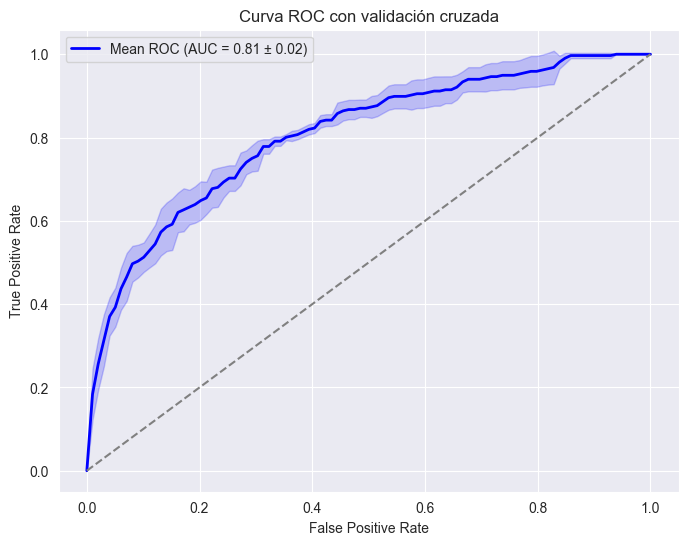

In [107]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Guardar el FPR y TPR para cada fold
tprs = []
mean_fpr = np.linspace(0, 1, 100)  # Puntos de interpolación
aucs = []

# Validación cruzada
y_train_array = y_train.to_numpy()
model = grid_search_l1.best_estimator_

for train_idx, val_idx in inner_cv.split(X_train_transformed, y_train_array):
    X_train_fold, X_val_fold = X_train_transformed[train_idx], X_train_transformed[val_idx]
    y_train_fold, y_val_fold = y_train_array[train_idx], y_train_array[val_idx]
    
    model.fit(X_train_fold, y_train_fold)
    
    # Predecimos las probabilidades
    y_scores_fold = model.predict_proba(X_val_fold)[:, 1]
    
    # Cálculo de la curva ROC para el fold actual
    fpr, tpr, _ = roc_curve(y_val_fold, y_scores_fold)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Como los valores del FPR van a ser un poco diferentes para cada fold, hace falta interpolar los valores TPR a una escala FPR común
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0  # Comienzo de TPR en 0

# Media y desviación típica del TPR
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)

# Intervalo de confianza de la curva
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='blue', alpha=0.2)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Recta del modelo aleatorio

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC con validación cruzada")
plt.legend()
plt.show()

Podemos ver que el modelo encontrado con HPO es bastante mejor que el modelo aleatorio, pero todavía está bastante lejos de el modelo ideal con TPR=1 y FPR=0. Este gráfico nos puede ayudar a cambiar el valor del threshold de clasificación en caso de que demos más o menos importancia a los verdaderos positivos o a los falsos positivos.

## Log Reg L1 con HPO: análisis de la curva de calibración

Otra forma de visualizar las probabilidades predichas por el modelo en comparación a las probabilidades observadas en el conjunto de entrenamiento es la curva de calibración, explicada en https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html. Para obtener esta curva predecimos las probabilidades de cada instancia del conjunto de validación de un StratifiedKFold con el modelo con HP óptimos entrenado con el conjunto de train de ese fold. Agrupamos las instancias en 10 bins según las probabilidades predichas y calculamos la probabilidad actual de la clase positiva usando las clases reales en y_train. Esto nos permite comparar como de precisas son las probabilidades que obtenemos del modelo en comparación a la distribución de clases real.

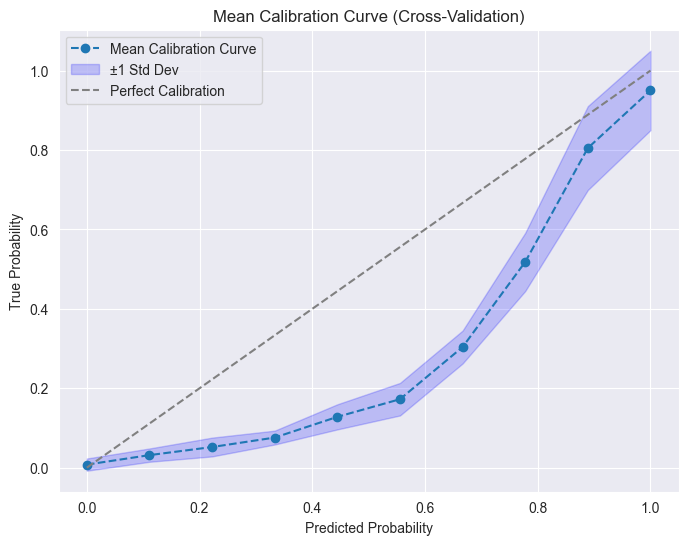

In [108]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

mean_prob_pred = np.linspace(0, 1, 10)
prob_trues = []

# Cross-validation
y_train_array = y_train.to_numpy()
model = grid_search_l1.best_estimator_

for train_idx, val_idx in inner_cv.split(X_train_transformed, y_train_array):
    X_train_fold, X_val_fold = X_train_transformed[train_idx], X_train_transformed[val_idx]
    y_train_fold, y_val_fold = y_train_array[train_idx], y_train_array[val_idx]
    
    model.fit(X_train_fold, y_train_fold)
    
    # Predecimos las probabilidades
    y_probs_val = model.predict_proba(X_val_fold)[:, 1]
    
    # Cálculo de la curva de calibración
    prob_true, prob_pred = calibration_curve(y_val_fold, y_probs_val, n_bins=10)

    # Interpolar para alinear las curvas
    interp_prob_true = np.interp(mean_prob_pred, prob_pred, prob_true)
    prob_trues.append(interp_prob_true)

# Media y desviación típica de las curvas del KFold
mean_prob_true = np.mean(prob_trues, axis=0)
std_prob_true = np.std(prob_trues, axis=0)

plt.figure(figsize=(8, 6))
plt.plot(mean_prob_pred, mean_prob_true, marker='o', linestyle="--", label="Mean Calibration Curve")
plt.fill_between(mean_prob_pred, mean_prob_true - std_prob_true, mean_prob_true + std_prob_true, 
                 color='blue', alpha=0.2, label="±1 Std Dev")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Mean Calibration Curve (Cross-Validation)")
plt.legend()
plt.show()


De la curva de calibración podemos ver que el modelo tiende a predecir probabilidades relativamente bajas comparadas con las probabilidades obtenidas de y_train, lo que puede tener sentido si consideramos que el problema está desbalanceado y hay muchas más instancias de clase negativa. Para probabilidades más altas (0.8-1) el modelo si se acerca más a la recta de calibración perfecta, lo que proporciona más confianza en las probabilidades altas del modelo (la mayoría de instancias que el modelo predice que tienen alta probabilidad de ser de la clase positiva son realmente de la clase positiva).

## Análisis comparativo de los modelos de regresión logística (sin Regularización vs L1 default vs L1 con HPO)

La optimización de hiperparámetros mejora significativamente la Balanced Accuracy en comparación con las otras dos versiones por defecto del modelo.  

Las mejoras más importantes las vemos en el TPR. El modelo optimizado con HPO detecta el 71.84% de los casos positivos, mientras que las versiones sin optimización tienen un rendimiento mucho peor, con apenas 24.05% (L1 default) y 29.11% (sin regularización). Los modelos sin optimización fallan al detectar la clase positiva, lo que los hace muy inadecuados.

El modelo L1 Default tiene el mayor TNR (97.38%), lo que significa que detecta muy bien los casos negativos (clase 0), pero esto viene con el coste de ignorar casi completamente los casos positivos.

En nuestro caso, que se trata de la predicción del abandono o burnout de empleados, minimizar los falsos negativos es generalmente más crítico. Opinamos que es preferible incurrir en algunos falsos positivos que pasar por alto a empleados que verdaderamente están en riesgo, ya que esto último puede tener consecuencias mucho más negativas para la empresa.

 La optimización de hiperparámetros logra un mejor balance entre detección de positivos y negativos, sacrificando un poco de TNR, pero mejorando drásticamente el TPR, lo que se traduce en valores de F1-score más equilibrados.




## Modelos avanzados: Support Vector Machines (SVMs)

## SVM: Entrenamiento con hiperparámetros por omisión

El clasificador Support Vector Classifier (SVC) de scikit-learn tiene los siguientes parámetros por defecto:

- C = 1.0: parámetro de regularización que controla El parámetro C controla el peso que le damos a la maximización del margen o la minimización de las holguras y permite controlar el sobreaprendizaje. Si C tiene un valor grande, se le da mucha importancia a que todos los datos de entrenamiento se clasifiquen correctamente.
- Kernel = 'rbf': especifica el kernel que se usará  para calcular la similitud entre el vector de soporte y la instancia a clasificar.
- class_weight = None: Ajuste de pesos en el algoritmo para contrarrestar el desbalanceo de clases.
- tol = 1e-3: tolerancia para la convergencia del algoritmo.

(Existen más hiperparametros pero como no los hemos visto en clase de teoría no hemos visto relevante incluirlos)

In [109]:
import time
from sklearn.svm import SVC

svc_default = SVC()  # Hiperparámetros por defecto

start_time = time.time()
svc_default.fit(X_train_transformed, y_train)
default_time_fit_svc = time.time() - start_time
print(f"Tiempo de entrenamiento de SVC default: {default_time_fit_svc:.8f} segundos")

Tiempo de entrenamiento de SVC default: 0.08011413 segundos


## Métricas del SVC default

Modelo SVC con hiperparámetros default  (evaluación inner con validación cruzada):
Balanced Accuracy: 0.6385
Accuracy: 0.8760

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1644
           1       0.83      0.29      0.43       316

    accuracy                           0.88      1960
   macro avg       0.86      0.64      0.68      1960
weighted avg       0.87      0.88      0.85      1960

Matriz de Confusión:
[[1626   18]
 [ 225   91]]
TPR: 0.2880
TNR: 0.9891

Tiempo de entrenamiento de SVC default: 0.08011413 segundos
Tiempo de predicción (CV) de SVC default: 0.39853573 segundos


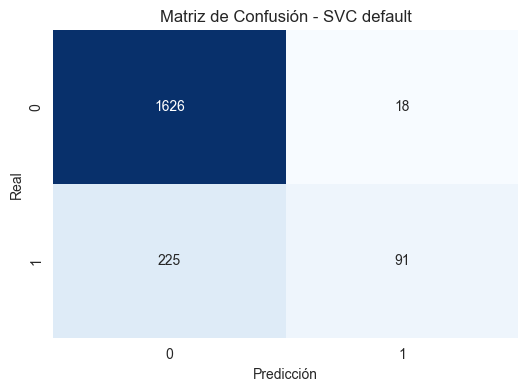

In [110]:
from sklearn.model_selection import cross_val_predict

# Utilizar cross_val_predict para obtener las predicciones mediante validación cruzada
start_time = time.time()
y_pred_cv = cross_val_predict(svc_default, X_train_transformed, y_train, cv=inner_cv)
default_time_predict = time.time() - start_time

# Calcular las métricas sobre el conjunto de entrenamiento (evaluación inner)
default_balanced_accuracy_svc = balanced_accuracy_score(y_train, y_pred_cv)
default_accuracy_svc = accuracy_score(y_train, y_pred_cv)
default_conf_matrix_svc = confusion_matrix(y_train, y_pred_cv)
default_class_report_svc = classification_report(y_train, y_pred_cv, zero_division=0)

# Calcular TPR y TNR a partir de la matriz de confusión
tn, fp, fn, tp = default_conf_matrix_svc.ravel()
TPR = tp / (tp + fn)
TNR = tn / (tn + fp)

# Imprimir los resultados
print("Modelo SVC con hiperparámetros default  (evaluación inner con validación cruzada):")
print(f"Balanced Accuracy: {default_balanced_accuracy_svc:.4f}")
print(f"Accuracy: {default_accuracy_svc:.4f}")
print("\nClassification Report:")
print(default_class_report_svc)
print("Matriz de Confusión:")
print(default_conf_matrix_svc)
print(f"TPR: {TPR:.4f}")
print(f"TNR: {TNR:.4f}")
print(f"\nTiempo de entrenamiento de SVC default: {default_time_fit_svc:.8f} segundos")
print(f"Tiempo de predicción (CV) de SVC default: {default_time_predict:.8f} segundos")

# Visualizar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(default_conf_matrix_svc, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - SVC default")
plt.show()

## SVC: Evaluación de alternativas con ajustes de hiper-parámetros (HPO)

Realizaremos una búsqueda de hiperparámetros HPO para optimizar un clasificador SVC utilizando validación cruzada interna.

In [111]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignoramos las ConvergenceWarning ya que algunos modelos del grid search no convergen con 1000 iteraciones
warnings.simplefilter("ignore", ConvergenceWarning)
svc_hpo = SVC(max_iter=1000, random_state=72)

# Definimos el grid de hiperparámetros a optimizar
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],                # Fuerza de regularización (inverso), es el HP más importante
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],             # Función de similitud usada
    'class_weight': [None, 'balanced'],          # Ajustar pesos para contrarrestar el desbalanceo
    'tol': [1e-4, 1e-3, 1e-2]                     # Tolerancia para la convergencia
}

# GridSearchCV para la HPO
grid_search_svc = GridSearchCV(
    svc_hpo,
    param_grid,
    cv=inner_cv,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

# Medimos el tiempo de entrenamiento con HPO
start_hpo = time.time()
grid_search_svc.fit(X_train_transformed, y_train)
hpo_time_svc = time.time() - start_hpo

# Extraer los resultados en un dataframe
results_df_svc = pd.DataFrame(grid_search_svc.cv_results_)

# Seleccionar columnas 
results_df_svc = results_df_svc[
    ['param_C', 'param_kernel', 'param_class_weight', 'param_tol', 
     'mean_test_score', 'std_test_score', 'rank_test_score']
]

# Ordenar por el mejor Balanced Accuracy
results_df_svc = results_df_svc.sort_values(by='mean_test_score', ascending=False)

# Mostrar el DataFrame ordenado
display(results_df_svc)

print("Mejor hiperparámetros encontrados para modelo de SVC:")
print(grid_search_svc.best_params_)
print("Mejor Balanced Accuracy (CV):", grid_search_svc.best_score_)
print(f"\nTiempo de entrenamiento (HPO) en el conjunto de entrenamiento: {hpo_time_svc:.4f} segundos")


Fitting 5 folds for each of 120 candidates, totalling 600 fits


,param_C,param_kernel,param_class_weight,param_tol,mean_test_score,std_test_score,rank_test_score
115,100.00,rbf,balanced,0.0010,0.842888,0.036869,1
114,100.00,rbf,balanced,0.0001,0.842888,0.036869,1
103,100.00,rbf,None,0.0010,0.842888,0.036869,1
102,100.00,rbf,None,0.0001,0.842888,0.036869,1
116,100.00,rbf,balanced,0.0100,0.842888,0.036869,1
...,...,...,...,...,...,...,...
19,0.01,rbf,balanced,0.0010,0.500000,0.000000,96
35,0.10,sigmoid,None,0.0100,0.499392,0.001216,117
16,0.01,poly,balanced,0.0010,0.499045,0.003625,118
17,0.01,poly,balanced,0.0100,0.499045,0.003625,118


Mejor hiperparámetros encontrados para modelo de SVC:
{'C': 100, 'class_weight': None, 'kernel': 'rbf', 'tol': 0.0001}
Mejor Balanced Accuracy (CV): 0.8428883668585925

Tiempo de entrenamiento (HPO) en el conjunto de entrenamiento: 13.6564 segundos


In [112]:
# Obtener el mejor modelo obtenido en HPO
best_svc = grid_search_svc.best_estimator_

# Medir el tiempo de entrenamiento del mejor modelo sobre el conjunto de entrenamiento
start_best = time.time()
best_svc.fit(X_train_transformed, y_train)
best_svc_time = time.time() - start_best

# Tiempo total del proceso optimizado (HPO + entrenamiento del mejor modelo)
total_hpo_time_svc = hpo_time_svc + best_svc_time

print("Tiempo de entrenamiento del modelo default: {:.8f} segundos".format(default_time_fit_svc))
print("Tiempo de entrenamiento del proceso HPO (grid search): {:.4f} segundos".format(hpo_time_svc))
print("Tiempo de entrenamiento del best_svc: {:.4f} segundos".format(best_svc_time))
print("Tiempo total (HPO + entrenamiento del best modelo): {:.4f} segundos".format(total_hpo_time_svc))

# Calcular la mejora en el tiempo de entrenamiento comparando el total optimizado con el default
mejora_tiempo = total_hpo_time_svc / default_time_fit_svc
print("Factor de incremento en tiempo que supone la HPO y el entrenamiento del mejor modelo vs el default = {:.4f}".format(mejora_tiempo))


Tiempo de entrenamiento del modelo default: 0.08011413 segundos
Tiempo de entrenamiento del proceso HPO (grid search): 13.6564 segundos
Tiempo de entrenamiento del best_svc: 0.0661 segundos
Tiempo total (HPO + entrenamiento del best modelo): 13.7225 segundos
Factor de incremento en tiempo que supone la HPO y el entrenamiento del mejor modelo vs el default = 171.2863


## SVC con HPO: Gráficos de error para el estudio de los hiperparámetros

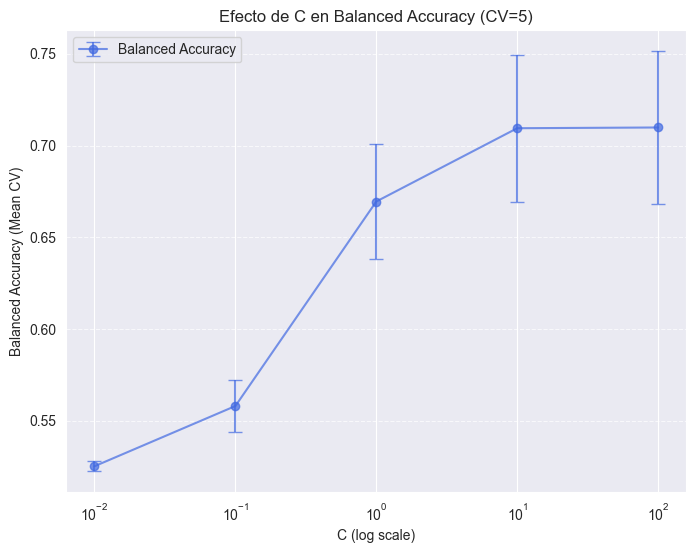

In [113]:
results_df_param_C = results_df_svc.groupby('param_C').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8, 6))

# Usamos plt.errorbar en vez de plt.bar porque facilita la representación de gráficos de error en escala logarítmica
plt.errorbar(results_df_param_C['param_C'],
             results_df_param_C['mean_balanced_accuracy'],
             yerr=results_df_param_C['std_balanced_accuracy'],
             fmt='o-', capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xscale('log')
plt.xlabel("C (log scale)")
plt.ylabel("Balanced Accuracy (Mean CV)")
plt.title(f"Efecto de C en Balanced Accuracy (CV={inner_cv.get_n_splits()})")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()


La obtención de mejores resultados con valores de C mayores (inverso de la regularización) indica de nuevo que los modelos simples no son suficientes para capturar los patrones y relaciones presentes en los datos (underfitting), como ya hemos visto en modelos anteriores y su tendecia a evitar hiperparámetros que los simplifiquen.

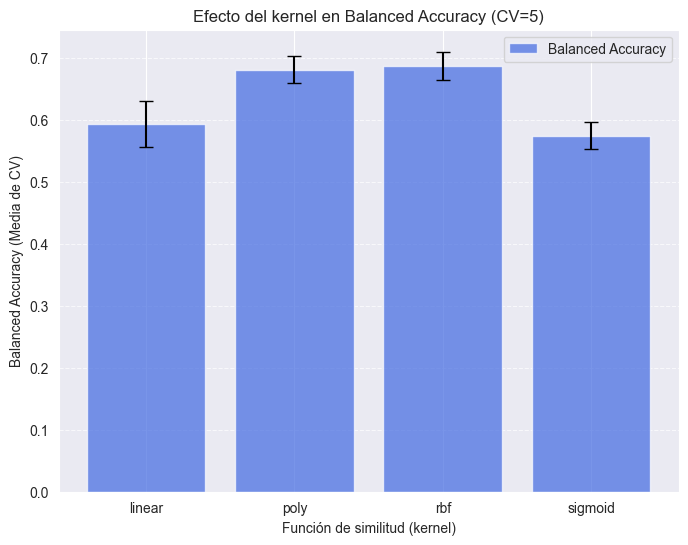

In [114]:
results_df_param_kernel = results_df_svc.groupby('param_kernel').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8, 6))

plt.bar(results_df_param_kernel['param_kernel'],
        results_df_param_kernel['mean_balanced_accuracy'],
        yerr=results_df_param_kernel['std_balanced_accuracy'],
        capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xlabel("Función de similitud (kernel)")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto del kernel en Balanced Accuracy (CV={inner_cv.get_n_splits()})")
plt.xticks(results_df_param_kernel['param_kernel'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()

El kernel que mejores resultados obtiene es rbf (Gaussiano) que también es el kernel más comunmente usado para Support Vector Machines y que calcula la similitud de los vectores en un espacio transformado de infinitas dimensiones. El kernel polynomial obtiene también resultados muy buenos ya que también permite fronteras de clasificación (decission boundary) más complejas que los kernels lineales.

### Resultados del SVC con HPO: balanced accuracy, TPR / TNR, accuracy y confusion matrix (inner)

Evaluación Inner para SVC optimizado (HPO):
Balanced Accuracy (CV): 0.8430
Accuracy: 0.9296

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1644
           1       0.82      0.72      0.77       316

    accuracy                           0.93      1960
   macro avg       0.89      0.84      0.86      1960
weighted avg       0.93      0.93      0.93      1960

Matriz de Confusión:
[[1596   48]
 [  90  226]]
TPR: 0.7152
TNR: 0.9708


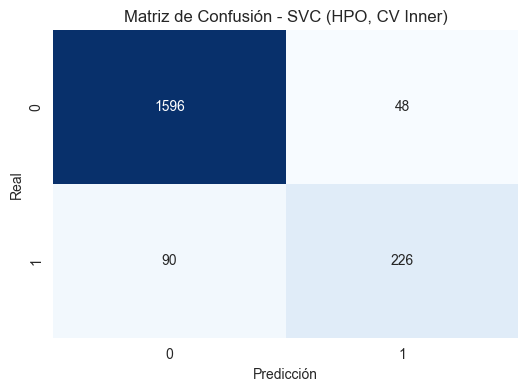

In [115]:
# Extraemos el modelo optimizado
best_svc = grid_search_svc.best_estimator_

# Usamos cross_val_predict para obtener las predicciones en validación cruzada
y_pred_cv_hpo_svc = cross_val_predict(best_svc, X_train_transformed, y_train, cv=inner_cv)

# Calcular las métricas en el conjunto de entrenamiento
inner_bal_acc_hpo_svc = balanced_accuracy_score(y_train, y_pred_cv_hpo_svc)
inner_acc_hpo_svc = accuracy_score(y_train, y_pred_cv_hpo_svc)
inner_class_report_hpo_SVC = classification_report(y_train, y_pred_cv_hpo_svc, zero_division=0)

print("Evaluación Inner para SVC optimizado (HPO):")
print(f"Balanced Accuracy (CV): {inner_bal_acc_hpo_svc:.4f}")
print(f"Accuracy: {inner_acc_hpo_svc:.4f}")
print("\nClassification Report:\n", inner_class_report_hpo_SVC)

# Calcular la matriz de confusión
inner_conf_matrix_hpo_svc = confusion_matrix(y_train, y_pred_cv_hpo_svc)
print("Matriz de Confusión:")
print(inner_conf_matrix_hpo_svc)

# Calcular TPR y TNR
tn, fp, fn, tp = inner_conf_matrix_hpo_svc.ravel()
TPR_hpo_svc = tp / (tp + fn)
TNR_hpo_svc = tn / (tn + fp)
print(f"TPR: {TPR_hpo_svc:.4f}")
print(f"TNR: {TNR_hpo_svc:.4f}")

# Visualizar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(inner_conf_matrix_hpo_svc, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - SVC (HPO, CV Inner)")
plt.show()

### SVC con HPO: Mapa de calor

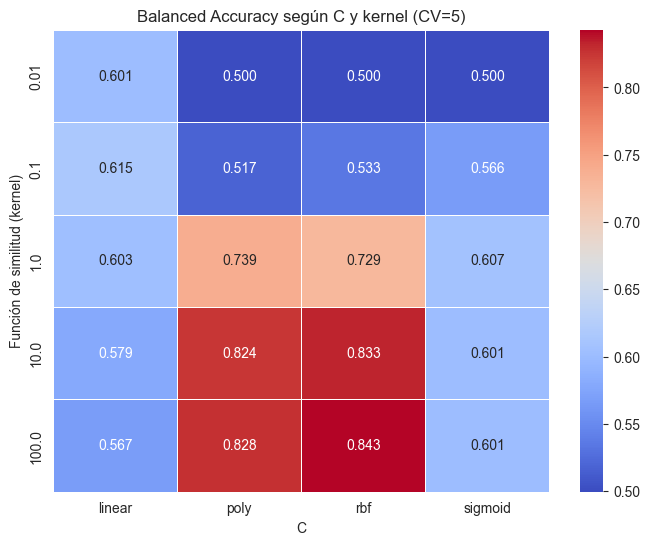

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una tabla pivote para el heatmap (C vs kernel) mostrando mean_test_score
heatmap_data_svc = results_df_svc.pivot_table(
    index='param_C', columns='param_kernel', values='mean_test_score', aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data_svc, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)

plt.xlabel("C")
plt.ylabel("Función de similitud (kernel)")
plt.title(f"Balanced Accuracy según C y kernel (CV={inner_cv.get_n_splits()})")

plt.show()

Vemos que el kernel gaussiano es ligeramente mejor que el polinomial para todos los valores de C y que valores menores de regularización (C mayor) resultan en modelos mejores para estos dos kernels.

## SVC con HPO: análisis de la curva ROC

La curva ROC tmabién se puede calcular para Support Vector Classifiers, ya que podemos cambiar el criterio que establece la frontera de clasificación y calcular los valores de TPR y FPR resultantes. En el caso de SVC el método decision_function nos da la distancia de una instancia al hiperplano de clasificación, lo que puede usarse como una métrica de confianza en la clasificación. Cambios en el threshold de clasificación son equivalentes son equivalentes a mover el hiperplano que separa las clases para cambiar las predicciones de las instancias cercanas a la frontera a la clase opuesta, cambiando así el TPR y el FPR.

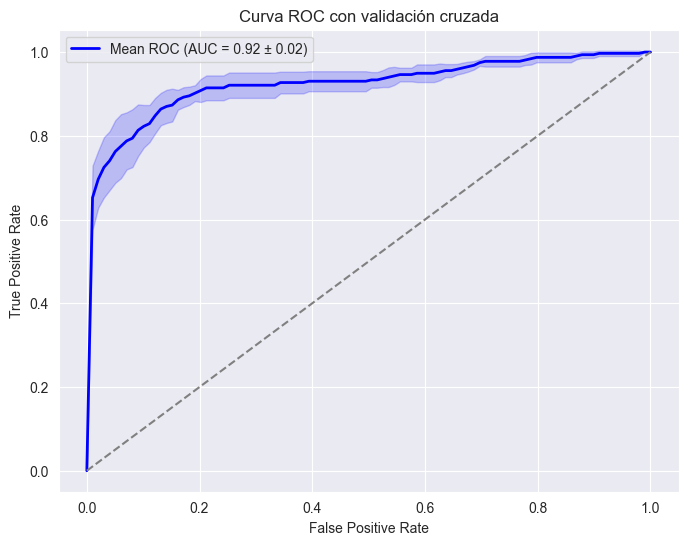

In [117]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Guardar el FPR y TPR para cada fold
tprs = []
mean_fpr = np.linspace(0, 1, 100)  # Puntos de interpolación
aucs = []

# Validación cruzada
y_train_array = y_train.to_numpy()
model = grid_search_svc.best_estimator_

for train_idx, val_idx in inner_cv.split(X_train_transformed, y_train_array):
    X_train_fold, X_val_fold = X_train_transformed[train_idx], X_train_transformed[val_idx]
    y_train_fold, y_val_fold = y_train_array[train_idx], y_train_array[val_idx]
    
    model.fit(X_train_fold, y_train_fold)
    
    # SVC no tiene método predict_proba, pero tiene el método decisión_function, que calcula la distancia de los puntos a la frontera de decisión, que puede usarse como una medida de fiabilidad de la predicción de manera similar a las probabilidades
    y_scores_fold = model.decision_function(X_val_fold)
    
    # Cálculo de la curva ROC para el fold actual
    fpr, tpr, _ = roc_curve(y_val_fold, y_scores_fold)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Como los valores del FPR van a ser un poco diferentes para cada fold, hace falta interpolar los valores TPR a una escala FPR común
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0  # Comienzo de TPR en 0

# Media y desviación típica del TPR
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)

# Intervalo de confianza de la curva
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='blue', alpha=0.2)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Recta del modelo aleatorio

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC con validación cruzada")
plt.legend()
plt.show()

La curva ROC del SVC con HPO indica que es un modelo can una buena capacidad de discriminación entre clases, ya que la curva está bastante cerca de la esquina superior izquierda.

## Extracción de atributos más relevantes

En scikitlearn es posible obtener los coeficientes de un SVC pero solo en el caso de que el hiperparámetro kernel=linear, pero como el modelo óptimo que hemos encontrado usa kernel=rbf hemos tenido que encontrar una alternativa para obtener los atributos relevantes.

Hemos usado la función permutation_importance de sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html), que permite encontrar la importancia de cada feature para cualquier modelo con el método fit. Esta función primero obtiene una métrica de validación para un conjunto de validación que se usará como base. Posteriormente va columna por columna del conjunto de entrenamiento y realiza permutaciones de los valores de esa columna (desordenamiento aleatorio), entrena un modelo nuevo con ese conjunto de entrenamiento y vuelve a obtener la métrica de validación. La importancia de cada atributo se calcula como la pérdida en el valor de la métrica cuando los valores de ese atributo han sido mezclados. Este proceso se basa en el hecho de que si los valores de un atributo relevante en una instancia real son incorrectos o hay ruido en ellos el modelo hará clasificaciones peores.

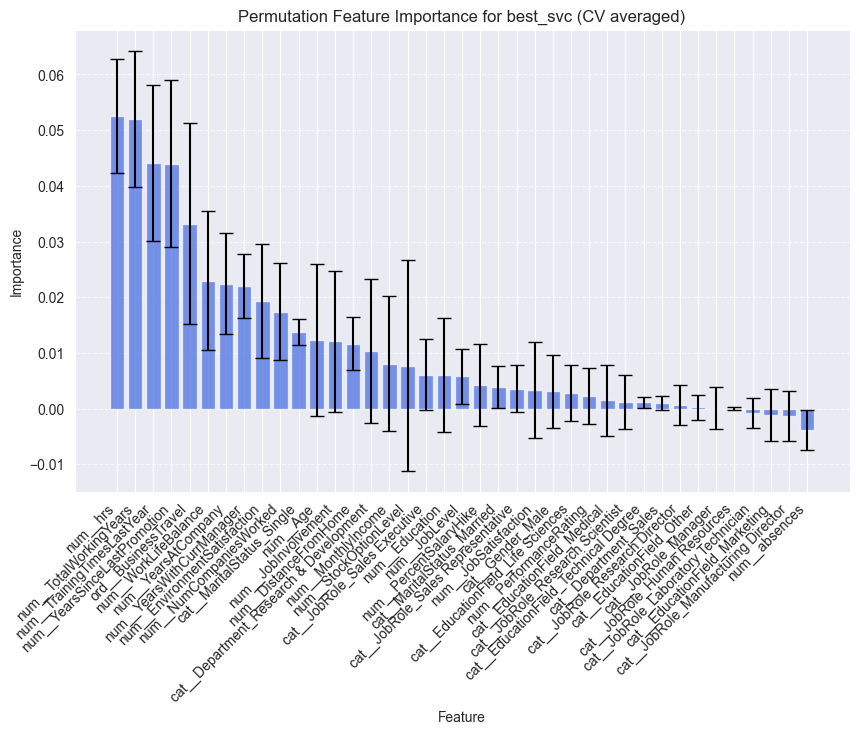

In [193]:
from sklearn.inspection import permutation_importance
import numpy as np

importances_all_folds = np.zeros((inner_cv.get_n_splits(), X_train_transformed.shape[1]))
model = grid_search_svc.best_estimator_

# Calculamos permutation importance para cada fold
for fold_idx, (train_idx, val_idx) in enumerate(inner_cv.split(X_train_transformed, y_train)):
    X_train_fold, X_val_fold = X_train_transformed[train_idx], X_train_transformed[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model.fit(X_train_fold, y_train_fold)
    
    # Calculamos permutation importance de todos los features en el fold actual
    result = permutation_importance(model, X_val_fold, y_val_fold, scoring="balanced_accuracy", n_repeats=15, random_state=72)
    
    importances_all_folds[fold_idx] = result.importances_mean  # Store feature importances for this fold

# Media y desvición típica de las importacias de cada feature
importances_mean = np.mean(importances_all_folds, axis=0)
importances_std = np.std(importances_all_folds, axis=0)

# Ordenar por la media de importancia descendente y añadir los nombres de la features
sorted_indices = importances_mean.argsort()[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = importances_mean[sorted_indices]
sorted_std = importances_std[sorted_indices]

# Mostrar los resultados añadiendo el error (desviación típica)
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importances, yerr=sorted_std, capsize=5, color='royalblue', alpha=0.7)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Permutation Feature Importance for best_svc (CV averaged)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Vemos que los atributos con alta importancia en el resto de modelos también resultan relevantes en el SVC. También hay un gran número de columnas que no proporcionan nada de información al modelo. Hay atributos que obtienen valores negativos de importancia, pero esto simplemente puede deberse a que son atributos irrrelevantes que al aleatoriezar sus valores generan resultados mínimamente mejores en el cálculo de la permutation importance por pura casualidad.

## Red Neuronal para clasificación (MLPClassifier)

Como tarea de elección abierta hemos decidido entrenar un Multi Layer Perceptron para clasificación, ya que vimos brevemente su funcionamiento en clase de teoría y nos pareció muy interesante. También esperamos que este modelo nos de resultados mucho mejores, ya que es bastante más complejo que los modelos vistos anteriormente y debido a esto puede que se le de mejor extraer los patrones y relaciones presentes en los datos.

## MLPClassifier: Entrenamiento con hiperparámetros por omisión

In [26]:
import time
from sklearn.neural_network import MLPClassifier

NN_default = MLPClassifier(max_iter=500, random_state=72)  # Hiperparámetros por defecto

start_time = time.time()
NN_default.fit(X_train_transformed, y_train)
default_time_fit_NN = time.time() - start_time
print(f"Tiempo de entrenamiento de la Neural Network default: {default_time_fit_NN:.8f} segundos")

Tiempo de entrenamiento de la Neural Network default: 5.49252915 segundos


## Métricas de la NN default

Modelo NN con hiperparámetros default  (evaluación inner con validación cruzada):
Balanced Accuracy: 0.8342
Accuracy: 0.9255

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1644
           1       0.81      0.70      0.75       316

    accuracy                           0.93      1960
   macro avg       0.88      0.83      0.85      1960
weighted avg       0.92      0.93      0.92      1960

Matriz de Confusión:
[[1593   51]
 [  95  221]]
TPR: 0.6994
TNR: 0.9690

Tiempo de entrenamiento de NN default: 1.80788207 segundos
Tiempo de predicción (CV) de NN default: 6.89402580 segundos


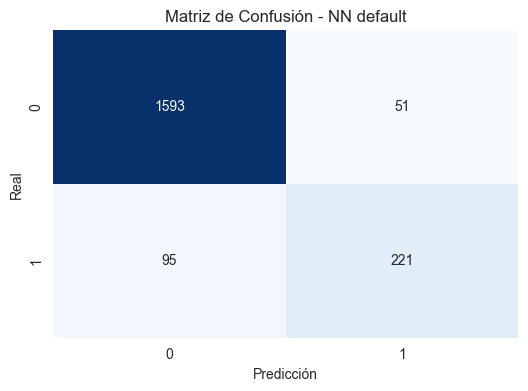

In [35]:
from sklearn.model_selection import cross_val_predict

# Utilizar cross_val_predict para obtener las predicciones mediante validación cruzada
start_time = time.time()
y_pred_cv = cross_val_predict(NN_default, X_train_transformed, y_train, cv=inner_cv)
default_time_predict = time.time() - start_time

# Calcular las métricas sobre el conjunto de entrenamiento (evaluación inner)
default_balanced_accuracy_NN = balanced_accuracy_score(y_train, y_pred_cv)
default_accuracy_NN = accuracy_score(y_train, y_pred_cv)
default_conf_matrix_NN = confusion_matrix(y_train, y_pred_cv)
default_class_report_NN = classification_report(y_train, y_pred_cv, zero_division=0)

# Calcular TPR y TNR a partir de la matriz de confusión
tn, fp, fn, tp = default_conf_matrix_NN.ravel()
TPR = tp / (tp + fn)
TNR = tn / (tn + fp)

# Imprimir los resultados
print("Modelo NN con hiperparámetros default  (evaluación inner con validación cruzada):")
print(f"Balanced Accuracy: {default_balanced_accuracy_NN:.4f}")
print(f"Accuracy: {default_accuracy_NN:.4f}")
print("\nClassification Report:")
print(default_class_report_NN)
print("Matriz de Confusión:")
print(default_conf_matrix_NN)
print(f"TPR: {TPR:.4f}")
print(f"TNR: {TNR:.4f}")
print(f"\nTiempo de entrenamiento de NN default: {default_time_fit_NN:.8f} segundos")
print(f"Tiempo de predicción (CV) de NN default: {default_time_predict:.8f} segundos")

# Visualizar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(default_conf_matrix_NN, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - NN default")
plt.show()

A primera vista el MLP tarda bastante más que el resto de modelos en entrenar, pero también proporciona resultados mucho mejores que el resto de modelos por defecto (es incluso mejor que el resto de modelos optimizados con HPO excepto el SVC).

## NN: Evaluación de alternativas con ajustes de hiper-parámetros (HPO)

Realizaremos una búsqueda de hiperparámetros HPO para optimizar un clasificador MLPClassifier utilizando validación cruzada interna.

In [120]:
NN_hpo = MLPClassifier(max_iter=200, random_state=72)

# Definimos el grid de hiperparámetros a optimizar
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # Numero de capas y número de neuronas artificiales por capa
    'activation': ['logistic', 'relu'],  # Función de activación usada
    'alpha': [0.001, 0.01, 0.1],  # Regularización L2
    'learning_rate_init': [0.001, 0.01, 0.1],  # Tasa de aprendizaje inicial
}

# GridSearchCV para la HPO
grid_search_NN = GridSearchCV(
    NN_hpo,
    param_grid,
    cv=inner_cv,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

# Medimos el tiempo de entrenamiento con HPO
start_hpo = time.time()
grid_search_NN.fit(X_train_transformed, y_train)
hpo_time_NN = time.time() - start_hpo

# Extraer los resultados en un dataframe
results_df_NN = pd.DataFrame(grid_search_NN.cv_results_)

# Seleccionar columnas 
results_df_NN = results_df_NN[
    ['param_hidden_layer_sizes', 'param_activation', 'param_alpha', 'param_learning_rate_init', 
     'mean_test_score', 'std_test_score', 'rank_test_score']
]

# Ordenar por el mejor Balanced Accuracy
results_df_NN = results_df_NN.sort_values(by='mean_test_score', ascending=False)

# Mostrar el DataFrame ordenado
display(results_df_NN)

print("Mejor hiperparámetros encontrados para modelo de la NN:")
print(grid_search_NN.best_params_)
print("Mejor Balanced Accuracy (CV):", grid_search_NN.best_score_)
print(f"\nTiempo de entrenamiento (HPO) en el conjunto de entrenamiento: {hpo_time_NN:.4f} segundos")


Fitting 5 folds for each of 72 candidates, totalling 360 fits


,param_hidden_layer_sizes,param_activation,param_alpha,param_learning_rate_init,mean_test_score,std_test_score,rank_test_score
43,"(50, 50)",relu,0.001,0.010,0.852613,0.029600,1
46,"(100, 50)",relu,0.001,0.010,0.844570,0.020304,2
37,"(50,)",relu,0.001,0.010,0.843721,0.023668,3
14,"(50,)",logistic,0.010,0.100,0.843216,0.034353,4
70,"(100, 50)",relu,0.100,0.010,0.842713,0.021003,5
...,...,...,...,...,...,...,...
30,"(50, 50)",logistic,0.100,0.001,0.635363,0.019226,68
15,"(100,)",logistic,0.010,0.001,0.634519,0.011462,69
33,"(100, 50)",logistic,0.100,0.001,0.634210,0.024435,70
24,"(50,)",logistic,0.100,0.001,0.626523,0.014701,71


Mejor hiperparámetros encontrados para modelo de la NN:
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01}
Mejor Balanced Accuracy (CV): 0.8526129572655909

Tiempo de entrenamiento (HPO) en el conjunto de entrenamiento: 116.4145 segundos


In [28]:
# Obtener el mejor modelo obtenido en HPO
best_NN = grid_search_NN.best_estimator_

# Medir el tiempo de entrenamiento del mejor modelo sobre el conjunto de entrenamiento
start_best = time.time()
best_NN.fit(X_train_transformed, y_train)
best_NN_time = time.time() - start_best

# Tiempo total del proceso optimizado (HPO + entrenamiento del mejor modelo)
total_hpo_time_NN = hpo_time_NN + best_NN_time

print("Tiempo de entrenamiento del modelo default: {:.8f} segundos".format(default_time_fit_NN))
print("Tiempo de entrenamiento del proceso HPO (grid search): {:.4f} segundos".format(hpo_time_NN))
print("Tiempo de entrenamiento del best_NN: {:.4f} segundos".format(best_NN_time))
print("Tiempo total (HPO + entrenamiento del best modelo): {:.4f} segundos".format(total_hpo_time_NN))

# Calcular la mejora en el tiempo de entrenamiento comparando el total optimizado con el default
mejora_tiempo = total_hpo_time_NN / default_time_fit_NN
print("Factor de incremento en tiempo que supone la HPO y el entrenamiento del mejor modelo vs el default = {:.4f}".format(mejora_tiempo))


Tiempo de entrenamiento del modelo default: 5.49252915 segundos
Tiempo de entrenamiento del proceso HPO (grid search): 94.0868 segundos
Tiempo de entrenamiento del best_NN: 0.2682 segundos
Tiempo total (HPO + entrenamiento del best modelo): 94.3550 segundos
Factor de incremento en tiempo que supone la HPO y el entrenamiento del mejor modelo vs el default = 17.1788


Haciendo HPO con el MLP hemos visto que pese a ser un modelo mucho mejor que el resto de los vistos en esta práctica si solo miramos las métricas, el proceso de HPO se hace bastante más pesado al aumentar mucho el tiempo de entrenamiento de cada fit. Debido a esto hemos decidido usar un grid relativamente pequeño, por lo que probablemente no hemos acabado encontrando los mejores valores para los hiperparámetros del modelo. Aun así, los mejores HP encontrados resultan en un modelo que aparentemente es mucho mejor que los encontrados en el resto de HPOs, aunque este no sea perfecto.

## NN con HPO: Gráficos de error para el estudio de los hiperparámetros

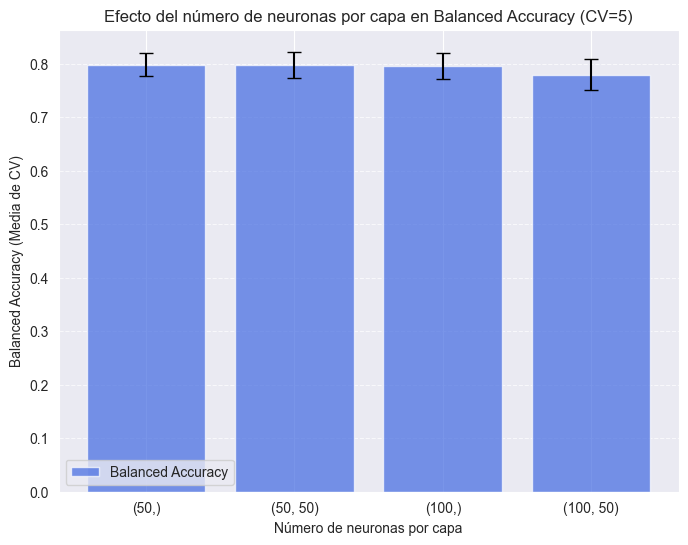

In [29]:
results_df_param_hidden_layer_sizes = results_df_NN.groupby('param_hidden_layer_sizes').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8, 6))

plt.bar(range(len(results_df_param_hidden_layer_sizes)),
        results_df_param_hidden_layer_sizes['mean_balanced_accuracy'],
        yerr=results_df_param_hidden_layer_sizes['std_balanced_accuracy'],
        capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xlabel("Número de neuronas por capa")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto del número de neuronas por capa en Balanced Accuracy (CV={inner_cv.get_n_splits()})")
plt.xticks(ticks=range(len(results_df_param_hidden_layer_sizes)), 
           labels=results_df_param_hidden_layer_sizes['param_hidden_layer_sizes'].astype(str))

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()

Las dimensiones de la red neuronal no parecen tener mucho efecto en los resultados del modelo, aunque tampoco podemos sacar conclusiones muy claras al haber probado pocos valores.

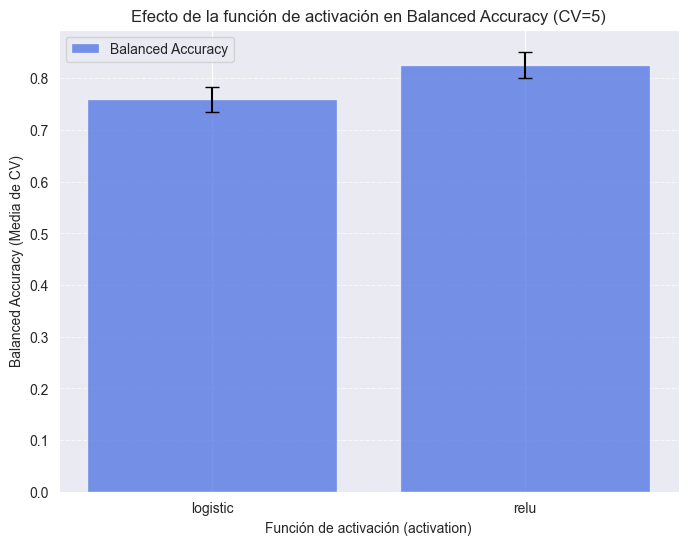

In [30]:
results_df_param_activation = results_df_NN.groupby('param_activation').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8, 6))

plt.bar(results_df_param_activation['param_activation'],
        results_df_param_activation['mean_balanced_accuracy'],
        yerr=results_df_param_activation['std_balanced_accuracy'],
        capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xlabel("Función de activación (activation)")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto de la función de activación en Balanced Accuracy (CV={inner_cv.get_n_splits()})")
plt.xticks(results_df_param_activation['param_activation'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()

La función de activación ReLU muestra resultados mejores que la función logística (sigmoide) lo que es bastante común en las redes de neuronas y hace que últimamente se haya sustituido el uso de la función sigmoide tradicionalmente usada en todas las redes neuronales. Una posible razón de esta diferencia de rendiemiento es que ReLU permite minimizar el impacto del problema de desvanecimiento de gradiente, lo que puede facilitar el entrenamiento con back-propagation y generar resultados más precisos.

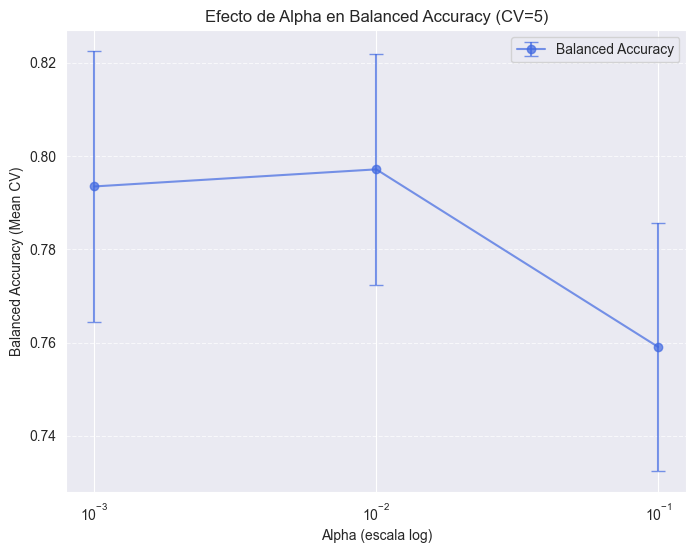

In [121]:
results_df_param_alpha = results_df_NN.groupby('param_alpha').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8, 6))

plt.errorbar(results_df_param_alpha['param_alpha'],
             results_df_param_alpha['mean_balanced_accuracy'],
             yerr=results_df_param_alpha['std_balanced_accuracy'],
             fmt='o-', capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xscale('log')
plt.xlabel("Alpha (escala log)")
plt.ylabel("Balanced Accuracy (Mean CV)")
plt.title(f"Efecto de Alpha en Balanced Accuracy (CV={inner_cv.get_n_splits()})")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()


El valor Alpha, que controla la regularización L2 aplicada a la red neuronal muestra que modelos demasiado simples (alpha=0.1) son mucho peores que con valores menores de regularización, pero cierta regularización (alpha=0.01) si ayuda al modelo a generalizar y genera resultados un poco mejores al evitar el overfitting.

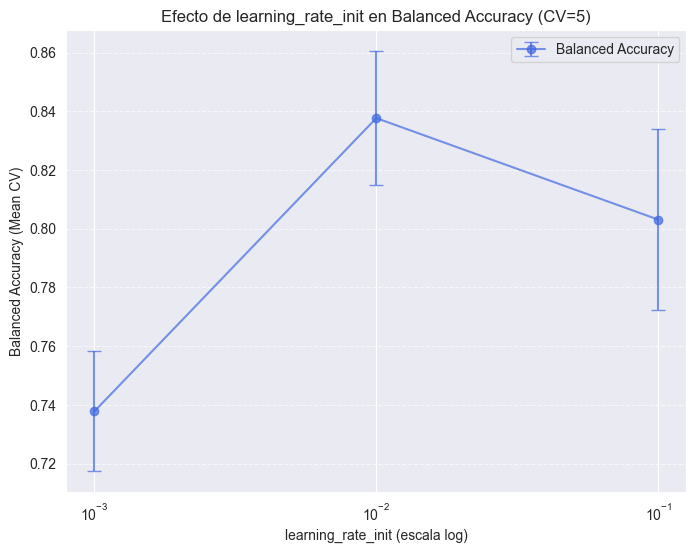

In [32]:
results_df_param_learning_rate_init = results_df_NN.groupby('param_learning_rate_init').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8, 6))

plt.errorbar(results_df_param_learning_rate_init['param_learning_rate_init'],
             results_df_param_learning_rate_init['mean_balanced_accuracy'],
             yerr=results_df_param_learning_rate_init['std_balanced_accuracy'],
             fmt='o-', capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xscale('log')
plt.xlabel("learning_rate_init (escala log)")
plt.ylabel("Balanced Accuracy (Mean CV)")
plt.title(f"Efecto de learning_rate_init en Balanced Accuracy (CV={inner_cv.get_n_splits()})")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()


Observamos que un valor intermedio para el valor inicial del learning rate es mejor que valores bajos que pueden quedarse atascados en mínimos locales y valores altos que pueden generar divergencia.

### Resultados de la NN con HPO: balanced accuracy, TPR / TNR, accuracy y confusion matrix (inner)

Evaluación Inner para NN optimizado (HPO):
Balanced Accuracy (CV): 0.8527
Accuracy: 0.9265

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      1644
           1       0.79      0.74      0.77       316

    accuracy                           0.93      1960
   macro avg       0.87      0.85      0.86      1960
weighted avg       0.93      0.93      0.93      1960

Matriz de Confusión:
[[1581   63]
 [  81  235]]
TPR: 0.7437
TNR: 0.9617


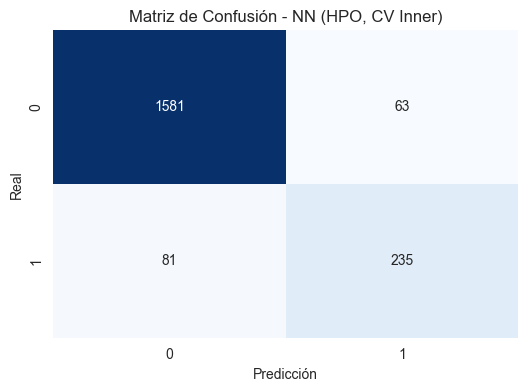

In [35]:
# Extraemos el modelo optimizado
best_NN = grid_search_NN.best_estimator_

# Usamos cross_val_predict para obtener las predicciones en validación cruzada
y_pred_cv_hpo_NN = cross_val_predict(best_NN, X_train_transformed, y_train, cv=inner_cv)

# Calcular las métricas en el conjunto de entrenamiento
inner_bal_acc_hpo_NN = balanced_accuracy_score(y_train, y_pred_cv_hpo_NN)
inner_acc_hpo_NN = accuracy_score(y_train, y_pred_cv_hpo_NN)
inner_class_report_hpo_NN = classification_report(y_train, y_pred_cv_hpo_NN, zero_division=0)

print("Evaluación Inner para NN optimizado (HPO):")
print(f"Balanced Accuracy (CV): {inner_bal_acc_hpo_NN:.4f}")
print(f"Accuracy: {inner_acc_hpo_NN:.4f}")
print("\nClassification Report:\n", inner_class_report_hpo_NN)

# Calcular la matriz de confusión
inner_conf_matrix_hpo_NN = confusion_matrix(y_train, y_pred_cv_hpo_NN)
print("Matriz de Confusión:")
print(inner_conf_matrix_hpo_NN)

# Calcular TPR y TNR
tn, fp, fn, tp = inner_conf_matrix_hpo_NN.ravel()
TPR_hpo_NN = tp / (tp + fn)
TNR_hpo_NN = tn / (tn + fp)
print(f"TPR: {TPR_hpo_NN:.4f}")
print(f"TNR: {TNR_hpo_NN:.4f}")

# Visualizar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(inner_conf_matrix_hpo_NN, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - NN (HPO, CV Inner)")
plt.show()

Los resultados obtenidos de la inner evaluation para la red neuronal son los mejores de los modelos vistos en este proyecto. Esto tiene sentido ya que es el modelo más avanzado y que mejor funciona para extraer relaciones entre los atributos y las clases de los datos. Aunque es verdad que los resultados son claramente mejores, los tiempos de entrenamiento aumentan drásticamente en comparacion a los otros modelos, lo que puede resultar inconveniente.

## NN con HPO: mapa de calor

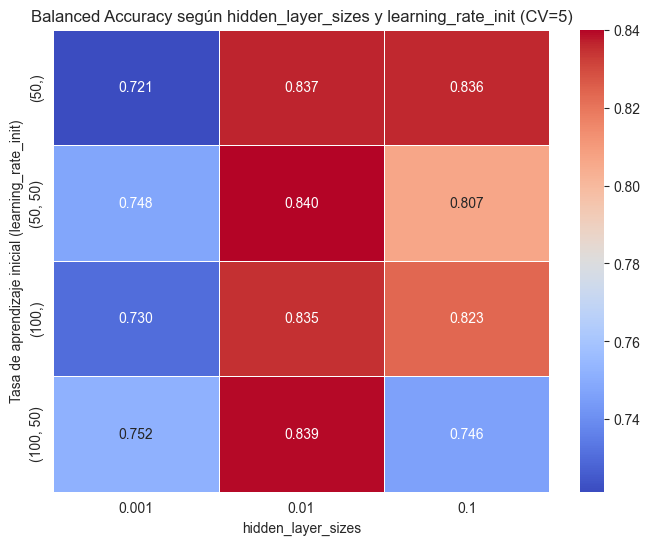

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una tabla pivote para el heatmap (hidden_layer_sizes vs learning_rate_init) mostrando mean_test_score
heatmap_data_NN = results_df_NN.pivot_table(
    index='param_hidden_layer_sizes', columns='param_learning_rate_init', values='mean_test_score', aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data_NN, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)

plt.xlabel("Tasa de aprendizaje inicial (learning_rate_init)")
plt.ylabel("hidden_layer_sizes")
plt.title(f"Balanced Accuracy según hidden_layer_sizes y learning_rate_init (CV={inner_cv.get_n_splits()})")

plt.show()

## NN con HPO: Curva de pérdida

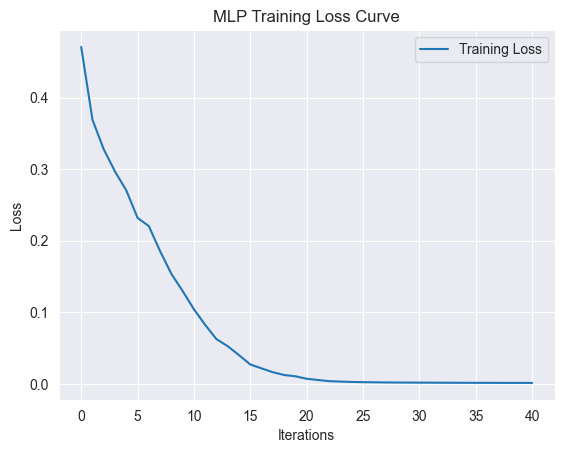

In [37]:
import matplotlib.pyplot as plt
best_NN = grid_search_NN.best_estimator_
best_NN.fit(X_train_transformed, y_train)

plt.plot(best_NN.loss_curve_, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MLP Training Loss Curve")
plt.legend()
plt.show()

La curva de pérdida nos muestra como el modelo óptimo evoluciona con el entramiento, reduciendo iterativamente el error. La curva obtenida muestra buenos resultados, decreciendo rápidamente al principio y suavemente aplanandose en el valor 0.0 a partir de la iteración 15. La curva muestra algunas partes con picos pronunciados, lo que puede indicar que el learning rate es demasiado alto o que hay datos ruidosos que dificultan el aprendizaje.

## NN con HPO: curva ROC

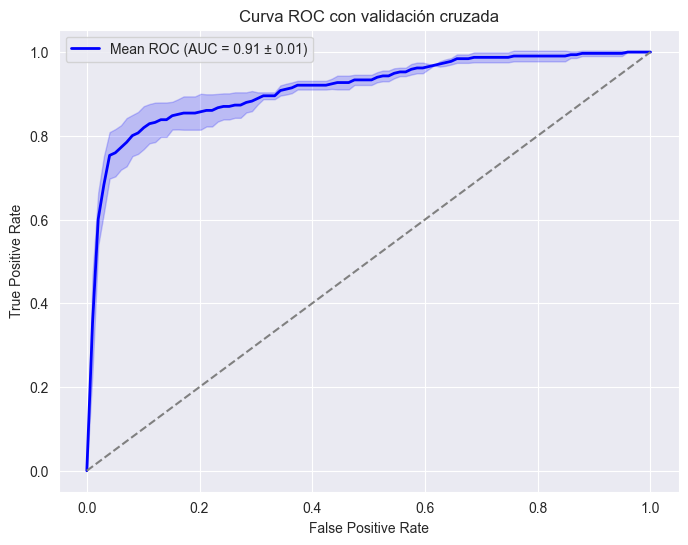

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Guardar el FPR y TPR para cada fold
tprs = []
mean_fpr = np.linspace(0, 1, 100)  # Puntos de interpolación
aucs = []

# Validación cruzada
y_train_array = y_train.to_numpy()
model = grid_search_NN.best_estimator_

for train_idx, val_idx in inner_cv.split(X_train_transformed, y_train_array):
    X_train_fold, X_val_fold = X_train_transformed[train_idx], X_train_transformed[val_idx]
    y_train_fold, y_val_fold = y_train_array[train_idx], y_train_array[val_idx]
    
    model.fit(X_train_fold, y_train_fold)
    
    # Predecimos las probabilidades
    y_scores_fold = model.predict_proba(X_val_fold)[:, 1]
    
    # Cálculo de la curva ROC para el fold actual
    fpr, tpr, _ = roc_curve(y_val_fold, y_scores_fold)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Como los valores del FPR van a ser un poco diferentes para cada fold, hace falta interpolar los valores TPR a una escala FPR común
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0  # Comienzo de TPR en 0

# Media y desviación típica del TPR
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)

# Intervalo de confianza de la curva
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='blue', alpha=0.2)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Recta del modelo aleatorio

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC con validación cruzada")
plt.legend()
plt.show()

El MLPClassifier optimizado presenta una curva ROC bastante buena que se acerca a la esquina superior izquierda. Es bastante similar a la curva obtenida para el SVC, lo que tiene sentido ya que ambos modelos presentan métricas bastante similares.

## Extracción de atributos relevantes

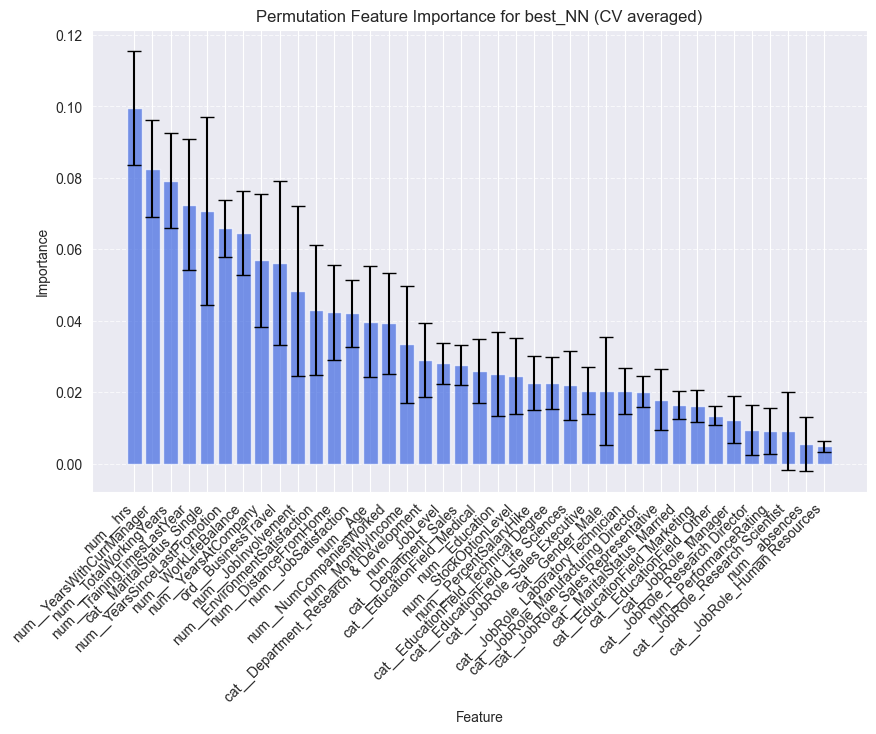

In [41]:
from sklearn.inspection import permutation_importance
import numpy as np

importances_all_folds = np.zeros((inner_cv.get_n_splits(), X_train_transformed.shape[1]))
model = grid_search_NN.best_estimator_

# Calculamos permutation importance para cada fold
for fold_idx, (train_idx, val_idx) in enumerate(inner_cv.split(X_train_transformed, y_train)):
    X_train_fold, X_val_fold = X_train_transformed[train_idx], X_train_transformed[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model.fit(X_train_fold, y_train_fold)
    
    # Calculamos permutation importance de todos los features en el fold actual
    result = permutation_importance(model, X_val_fold, y_val_fold, scoring="balanced_accuracy", n_repeats=15, random_state=72)
    
    importances_all_folds[fold_idx] = result.importances_mean  # Store feature importances for this fold

# Media y desvición típica de las importacias de cada feature
importances_mean = np.mean(importances_all_folds, axis=0)
importances_std = np.std(importances_all_folds, axis=0)

# Ordenar por la media de importancia descendente y añadir los nombres de la features
sorted_indices = importances_mean.argsort()[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = importances_mean[sorted_indices]
sorted_std = importances_std[sorted_indices]

# Mostrar los resultados añadiendo el error (desviación típica)
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importances, yerr=sorted_std, capsize=5, color='royalblue', alpha=0.7)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Permutation Feature Importance for best_NN (CV averaged)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Los atributos más importantes para el MLPClassifier optimizado son casi los mismos que los atributos relevantes para los modelos vistos previamente, pero en este caso la red neuronal también encuentra cierta importancia para los atributos menos importantes mientras que los otros modelos (logReg y SVC) daban 0 importancia a estos atributos. Esto puede deberse a que al ser un modelo más complicado, la red neuronal consigue extraer patrones presentes en estos atributos que los otros dos modelos pasan por alto.

## Comparación de resultados de todos los modelos

In [118]:
import pandas as pd
import re

# Resultados de los classification_report() de cada inner evaluation (modelos con HPO)
reports = {
    "KNN": inner_class_report_hpo_KNN,
    "Tree": inner_class_report_hpo_tree,
    "LogReg_L1": inner_class_report_hpo_logreg_l1,
    "SVC": inner_class_report_hpo_SVC,
    "NN" : inner_class_report_hpo_NN
}

# Métricas calculadas en cada inner evaluation (modelos con HPO)
model_metrics = {
    "KNN": {"accuracy": inner_acc_hpo_KNN, "balanced_accuracy": inner_bal_acc_hpo_KNN, "TPR": TPR_hpo_KNN, "TNR": TNR_hpo_KNN, "HPO_time": hpo_time_KNN},
    "Tree": {"accuracy": inner_acc_hpo_tree, "balanced_accuracy": inner_bal_acc_hpo_tree, "TPR": TPR_hpo_tree, "TNR": TNR_hpo_tree, "HPO_time": hpo_time_tree},
    "LogReg_L1": {"accuracy": inner_acc_hpo_logreg_l1, "balanced_accuracy": inner_bal_acc_hpo_logreg_l1, "TPR": TPR_hpo_logreg_l1, "TNR": TNR_hpo_logreg_l1, "HPO_time": hpo_time_logreg_l1},
    "SVC": {"accuracy": inner_acc_hpo_svc, "balanced_accuracy": inner_bal_acc_hpo_svc, "TPR": TPR_hpo_svc, "TNR": TNR_hpo_svc, "HPO_time": hpo_time_svc},
    "NN": {"accuracy": inner_acc_hpo_NN, "balanced_accuracy": inner_bal_acc_hpo_NN, "TPR": TPR_hpo_NN, "TNR": TNR_hpo_NN, "HPO_time": hpo_time_NN}
}

# Función para parsear las strings que devuelve classification_report() y extraer los atributos relevantes
def parse_classification_report(report_string):
    lines = report_string.split("\n")
    data = []
    # Regex para obtener las líneas que contienen class_label, precision, recall, f1 y support y extraer estos campos
    pattern = re.compile(r"(\S+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+(\d+)")
    
    for line in lines:
        match = pattern.match(line.strip())
        if match:
            class_label, precision, recall, f1, support = match.groups()
            # Los classification reports de SKlearn muestran los valores de Precission, Recall y F1-Score para ambas clases, aunque en las diapos de clase solo se calcula el de la clase 1 (positivo). Hemos decidido mostrar solo las métricas de la clase positiva por simplicidad.
            if class_label == "1":
                data.append([float(precision), float(recall), float(f1)])
    
    return pd.DataFrame(data, columns=["Precision", "Recall", "F1-Score"])  # class_label y support no nos interesan

# Convertir cada report a un df
df_list = []
for model, report_str in reports.items():
    df = parse_classification_report(report_str)
    df["Model"] = model
    
    # Añadir las otras métricas calculadas
    df["Accuracy"] = model_metrics[model]["accuracy"]
    df["Balanced Accuracy"] = model_metrics[model]["balanced_accuracy"]
    df["TPR"] = model_metrics[model]["TPR"]
    df["TNR"] = model_metrics[model]["TNR"]
    df["HPO_time"] = model_metrics[model]["HPO_time"]
    
    df_list.append(df)

# Combinar todas las filas en una df
final_df = pd.concat(df_list, ignore_index=True)
final_df = final_df[['Model', 'Precision', 'Recall', 'F1-Score', 'Accuracy', 'Balanced Accuracy', 'TPR', 'TNR', 'HPO_time']]

display(final_df)

,Model,Precision,Recall,F1-Score,Accuracy,Balanced Accuracy,TPR,TNR,HPO_time
0,KNN,0.78,0.68,0.73,0.917347,0.821638,0.680380,0.962895,9.637853
1,Tree,0.67,0.68,0.68,0.894388,0.809230,0.683544,0.934915,13.646652
2,LogReg_L1,0.34,0.73,0.46,0.728061,0.727975,0.727848,0.728102,9.374770
3,SVC,0.82,0.72,0.77,0.929592,0.842996,0.715190,0.970803,13.656380
4,NN,0.79,0.74,0.77,0.926531,0.852675,0.743671,0.961679,94.086799


Basandonos en la balanced accuracy, que es la métrica que hemos usado durante toda esta práctica el orden de los modelos de mejor a peor es NN, SVC, KNN, Tree y LogReg_L1. Como la balanced accuracy de los dos mejores modelos es bastante similar, podemos usar una segunda métrica para decidir cual elegir. La segunda métrica que nos parece más interesante es el TPR/Recall, que indica que porcentaje de las instancias positivas son correctamente clasificadas por el modelo. La razón es que en este problema de clasificación consideramos que lo más importante identificar correctamente a los empleados que sufren de agotamiento para poder intentar remediarlo a tiempo antes de que esto cause un abandono, pese a que un TPR alto pueda causar algunos falsos positivos que no resultan tan graves. Otro factor importante para elegir entre estos dos modelos es el tiempo de entrenamiento reflejado en HPO_time. Si se planea usar el modelo elegido en una competición o en una empresa que no planea cambiar el modelo este tiempo no es un factor tan importante, pero si existe la necesidad de reentrenar el modelo muy frecuentemente con datos nuevos o si el conjunto de entrenamiento usado se vuelve obsoleto estos altos tiempos de entrenamiento pueden resultar inconvenientes. 

Con las consideraciones anteriores hemos decidido elegir la red neuronal (MLPClassifier) como el modelo final con el que realizaremos la outer evaluation y calcularemos las predicciones de competición.

## Evalución de rendimiento futuro (Outer)

Evaluación Outer para NN optimizado (HPO):
Balanced Accuracy (CV): 0.8795
Accuracy: 0.9480

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       822
           1       0.88      0.78      0.83       158

    accuracy                           0.95       980
   macro avg       0.92      0.88      0.90       980
weighted avg       0.95      0.95      0.95       980

Matriz de Confusión:
[[806  16]
 [ 35 123]]
TPR: 0.7785
TNR: 0.9805


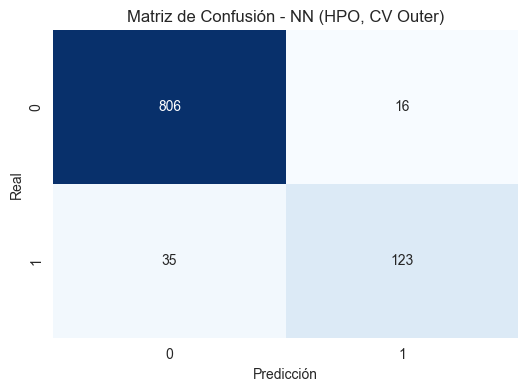

In [119]:
# Extraemos el modelo optimizado
best_NN = grid_search_NN.best_estimator_
best_NN.fit(X_train_transformed, y_train)

y_pred_outer_NN = best_NN.predict(X_test_transformed)

# Calcular las métricas en el conjunto de test
outer_bal_acc_hpo_NN = balanced_accuracy_score(y_test, y_pred_outer_NN)
outer_acc_hpo_NN = accuracy_score(y_test, y_pred_outer_NN)
outer_class_report_hpo_NN = classification_report(y_test, y_pred_outer_NN, zero_division=0)

print("Evaluación Outer para NN optimizado (HPO):")
print(f"Balanced Accuracy (CV): {outer_bal_acc_hpo_NN:.4f}")
print(f"Accuracy: {outer_acc_hpo_NN:.4f}")
print("\nClassification Report:\n", outer_class_report_hpo_NN)

# Calcular la matriz de confusión
outer_conf_matrix_hpo_NN = confusion_matrix(y_test, y_pred_outer_NN)
print("Matriz de Confusión:")
print(outer_conf_matrix_hpo_NN)

# Calcular TPR y TNR
tn, fp, fn, tp = outer_conf_matrix_hpo_NN.ravel()
TPR_outer_NN = tp / (tp + fn)
TNR_outer_NN = tn / (tn + fp)
print(f"TPR: {TPR_outer_NN:.4f}")
print(f"TNR: {TNR_outer_NN:.4f}")

# Visualizar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(outer_conf_matrix_hpo_NN, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - NN (HPO, CV Outer)")
plt.show()

## Serialización del modelo final

In [123]:
import pickle

best_NN_final = grid_search_NN.best_estimator_  # Hiperparámetros encontrados en la HPO inner

X_transformed = best_preprocessor.named_steps['preprocessing'].transform(X) # Preprocesamos todos los datos para entrenar con ellos

best_NN_final.fit(X_transformed, y)

filename = "modelo_final.pkl"

pickle.dump(best_NN_final, open(filename, "wb"))
